<br><br>
<img src='https://www.riotgames.com/darkroom/1000/fab68f870f6da8998086165e608ea621:659056e32b0511d7f8525348809721ff/tft.jpg' width="700px">  
<br>

# Team Fight Tactics Challengers games analysis

Put your team-building skills to the test in Teamfight Tactics, the ultimate PvP strategy game from the studio behind League of Legends.

The game centers around eight players who construct teams to fight one another and be the last player standing. The battlefield consists of hexagons, where players can strategically place units on the hexagons on their side of the game board between rounds. During each round, a short battle automatically commences, with two players matched randomly for that round, or else paired against computer-controlled enemies. In the rounds against computer-controlled enemies, each enemy has a chance to drop gold, units, or items that the player can use. Health lost from losing a round is calculated with a combination of set damage per round and how many units an opponent had still alive.


**Set**
Dragonlands 	June 8, 2022 	Dragons

## **Objective** of this notebook to analysis the best strategy to use for Team Fight Tactics.

8 players FFA in one game.

**Target Label**: *placement*
1 is best. Lower is better.

In [1168]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [1169]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'na'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196'

TARGETNAME = 'placement'

In [1170]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_matches.pickle'))

In [1171]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Dragon,Set7_Evoker,Set7_Jade,Set7_Legend,Set7_Mystic,...,TFT7_Kayn_item1,TFT7_Kayn_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_TahmKench_item1,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_TahmKench_item2,TFT7_Skarner_item2,TFT7_Senna_item2
0,KR_5993867535,7,TFT6_Augment_SalvageBin,TFT6_Augment_RadiantRelics,TFT6_Augment_ComponentGrabBag,1.0,0.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KR_5993867535,2,TFT6_Augment_SunfireBoard,TFT7_Augment_CavalierEmblem2,TFT7_Augment_DragonHorde,2.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KR_5993867535,4,TFT6_Augment_PortableForge,TFT6_Augment_BandOfThieves2,TFT6_Augment_CyberneticShell2,NaN,0.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KR_5993867535,5,TFT6_Augment_SunfireBoard,TFT6_Augment_MaxLevel10,TFT7_Augment_GuildEmblem,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KR_5993867535,3,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_RadiantRelics,TFT6_Augment_PortableForge,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13259,KR_5991027338,3,TFT6_Augment_PandorasItems,TFT6_Augment_Electrocharge2,TFT6_Augment_Diversify3,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13260,KR_5991027338,5,TFT6_Augment_TinyTitans,TFT7_Augment_CannoneerEmblem,TFT6_Augment_HighEndShopping,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13261,KR_5991027338,8,TFT6_Augment_Weakspot,TFT7_Augment_UrfsGrabBag1,TFT7_Augment_UrfsGrabBag2,NaN,0.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13262,KR_5991027338,4,TFT6_Augment_LudensEcho1,TFT6_Augment_CelestialBlessing2,TFT6_Augment_GrandGambler,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1172]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [1173]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 22.53 Mb (16.6% reduction)


In [1174]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Dragon,Set7_Evoker,Set7_Jade,Set7_Legend,Set7_Mystic,...,TFT7_Kayn_item1,TFT7_Kayn_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_TahmKench_item1,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_TahmKench_item2,TFT7_Skarner_item2,TFT7_Senna_item2
1,KR_5993867535,2,TFT6_Augment_SunfireBoard,TFT7_Augment_CavalierEmblem2,TFT7_Augment_DragonHorde,2.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KR_5993867535,4,TFT6_Augment_PortableForge,TFT6_Augment_BandOfThieves2,TFT6_Augment_CyberneticShell2,NaN,0.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KR_5993867535,5,TFT6_Augment_SunfireBoard,TFT6_Augment_MaxLevel10,TFT7_Augment_GuildEmblem,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KR_5993867535,3,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_RadiantRelics,TFT6_Augment_PortableForge,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KR_5993867535,1,TFT6_Augment_Electrocharge2,TFT6_Augment_ThriftShop,TFT6_Augment_Ascension,1.0,NaN,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13259,KR_5991027338,3,TFT6_Augment_PandorasItems,TFT6_Augment_Electrocharge2,TFT6_Augment_Diversify3,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13260,KR_5991027338,5,TFT6_Augment_TinyTitans,TFT7_Augment_CannoneerEmblem,TFT6_Augment_HighEndShopping,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13261,KR_5991027338,8,TFT6_Augment_Weakspot,TFT7_Augment_UrfsGrabBag1,TFT7_Augment_UrfsGrabBag2,NaN,0.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13262,KR_5991027338,4,TFT6_Augment_LudensEcho1,TFT6_Augment_CelestialBlessing2,TFT6_Augment_GrandGambler,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1175]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [1176]:
# Check NA
check_NA(raw_df)

augment1                    1
augment2                   48
Set7_Dragon              5615
Set7_Evoker              7431
Set7_Jade                7086
                        ...  
TFT7_Senna_item0        13206
TFT7_Senna_item1        13235
TFT7_TahmKench_item2    13167
TFT7_Skarner_item2      13237
TFT7_Senna_item2        13252
Length: 264, dtype: int64


In [1177]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

In [1178]:
raw_df = impute(raw_df)

In [1179]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [1180]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [1181]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
KR_5993867535    8
KR_5991035960    8
KR_5991084510    8
KR_5991043117    8
KR_5988809384    8
                ..
KR_5989709773    8
KR_5989328858    8
KR_5989907302    8
KR_5990687456    8
KR_5991027338    8
Name: match_id, Length: 1658, dtype: int64 

augment0
TFT6_Augment_PortableForge         602
TFT6_Augment_TradeSector           379
TFT7_Augment_UrfsGrabBag1          378
TFT6_Augment_Ascension             370
TFT6_Augment_ThrillOfTheHunt2      368
                                  ... 
TFT6_Augment_FuturePeepers2          2
TFT7_Augment_AFKHR                   1
TFT6_Augment_CyberneticShell3        1
TFT7_Augment_RevelPartyFavorsHR      1
TFT6_Augment_Diversify2              1
Name: augment0, Length: 189, dtype: int64 

augment1
TFT6_Augment_SecondWind1           682
TFT6_Augment_TinyTitans            622
TFT6_Augment_ThrillOfTheHunt1      553
TFT6_Augment_ItemGrabBag1          468
TFT6_Augment_Weakspot              40

In [1182]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [1183]:
raw_df.describe()

,placement,Set7_Dragon,Set7_Evoker,Set7_Jade,Set7_Legend,Set7_Mystic,Set7_Shapeshifter,TFT7_Gnar,TFT7_Anivia,TFT7_Neeko,...,TFT7_Nidalee,TFT7_Elise,TFT7_Soraka,TFT7_Diana,TFT7_Lillia,TFT7_Skarner,TFT7_Kayn,TFT7_Aatrox,TFT7_AurelionSol,TFT7_Senna
count,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,...,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000,13264.000000
mean,4.500000,0.596200,0.235299,0.458685,0.099291,0.346200,0.293954,0.247437,0.331725,0.401236,...,0.080217,0.087455,0.202352,0.155835,0.114445,0.037922,0.102835,0.038450,0.012967,0.024352
std,2.291374,0.532248,0.440250,0.789232,0.299064,0.644328,0.594838,0.636301,0.747178,0.766122,...,0.476599,0.410463,0.522933,0.581507,0.460149,0.310893,0.428719,0.271603,0.139950,0.223267
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.250000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,2.000000,3.000000,3.000000,1.000000,4.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000


In [1184]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13264 entries, 0 to 13263
Columns: 267 entries, match_id to TFT7_Senna_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 22.5+ MB


2022-06-29 23:22:15,324 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


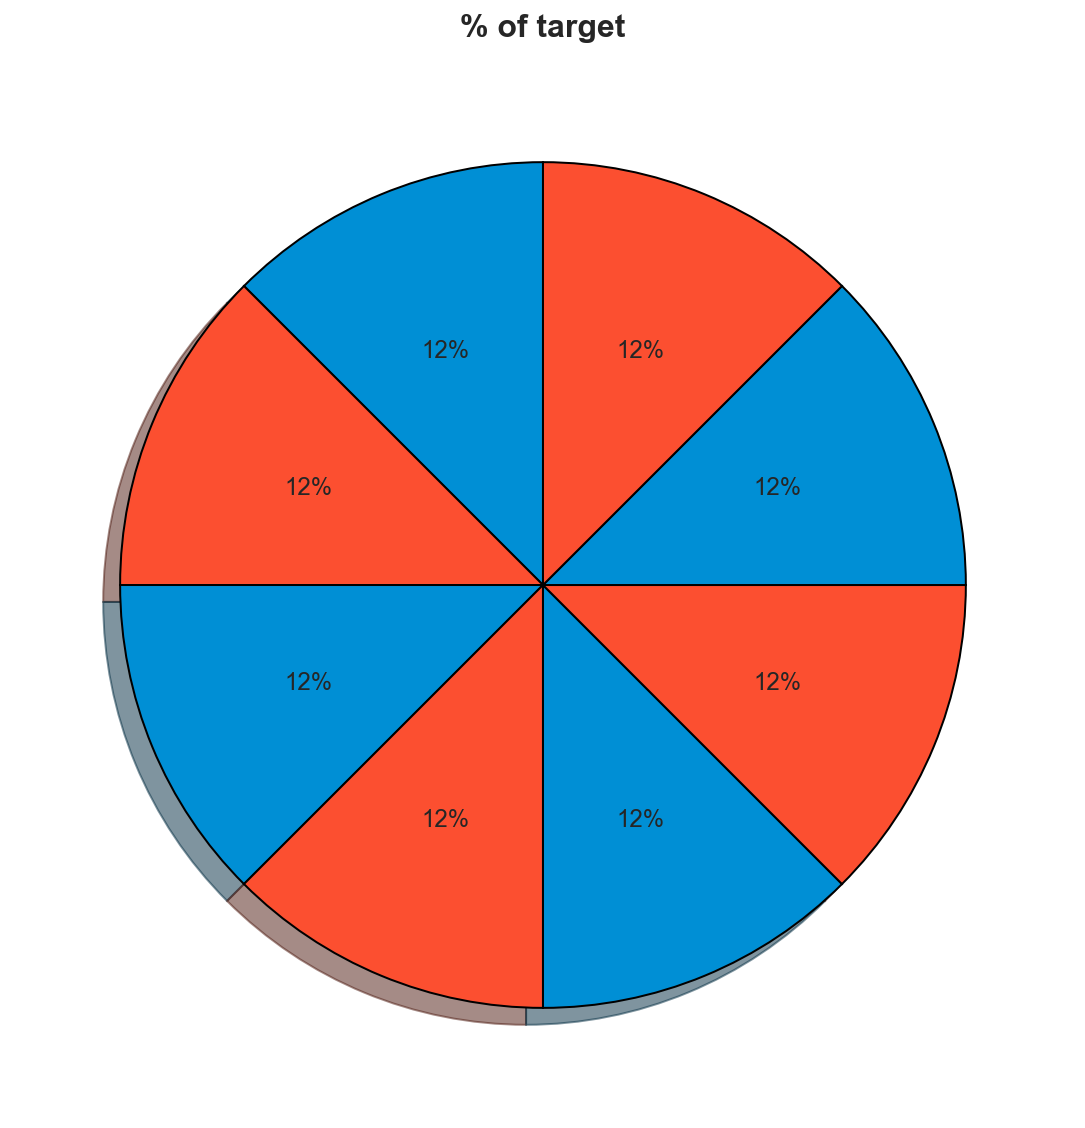

In [1185]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [1186]:
X = raw_df.drop(['match_id'], axis=1)


In [1187]:
y = X.pop(TARGETNAME)

In [1188]:
X.fillna('', inplace=True)

In [1189]:
X.dtypes

augment0                 object
augment1                 object
augment2                 object
Set7_Dragon             float32
Set7_Evoker             float32
                         ...   
TFT7_Senna_item0         object
TFT7_Senna_item1         object
TFT7_TahmKench_item2     object
TFT7_Skarner_item2       object
TFT7_Senna_item2         object
Length: 265, dtype: object

In [1190]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [1191]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [1192]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [1193]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13264 entries, 0 to 13263
Columns: 265 entries, augment0 to TFT7_Senna_item2
dtypes: int64(87), object(178)
memory usage: 26.8+ MB


In [1194]:
X

,augment0,augment1,augment2,Set7_Dragon,Set7_Evoker,Set7_Jade,Set7_Legend,Set7_Mystic,Set7_Shapeshifter,TFT7_Gnar,...,TFT7_Kayn_item1,TFT7_Kayn_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_TahmKench_item1,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_TahmKench_item2,TFT7_Skarner_item2,TFT7_Senna_item2
0,TFT6_Augment_SalvageBin,TFT6_Augment_RadiantRelics,TFT6_Augment_ComponentGrabBag,1,0,2,0,0,1,2,...,None,None,None,None,None,None,None,None,None,None
1,TFT6_Augment_SunfireBoard,TFT7_Augment_CavalierEmblem2,TFT7_Augment_DragonHorde,2,0,0,0,0,1,0,...,None,None,None,None,None,None,None,None,None,None
2,TFT6_Augment_PortableForge,TFT6_Augment_BandOfThieves2,TFT6_Augment_CyberneticShell2,0,0,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None
3,TFT6_Augment_SunfireBoard,TFT6_Augment_MaxLevel10,TFT7_Augment_GuildEmblem,0,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
4,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_RadiantRelics,TFT6_Augment_PortableForge,1,1,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13259,TFT6_Augment_PandorasItems,TFT6_Augment_Electrocharge2,TFT6_Augment_Diversify3,0,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
13260,TFT6_Augment_TinyTitans,TFT7_Augment_CannoneerEmblem,TFT6_Augment_HighEndShopping,1,1,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None
13261,TFT6_Augment_Weakspot,TFT7_Augment_UrfsGrabBag1,TFT7_Augment_UrfsGrabBag2,0,0,0,1,0,0,0,...,None,None,None,None,None,None,None,None,None,None
13262,TFT6_Augment_LudensEcho1,TFT6_Augment_CelestialBlessing2,TFT6_Augment_GrandGambler,0,1,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None


# Traits

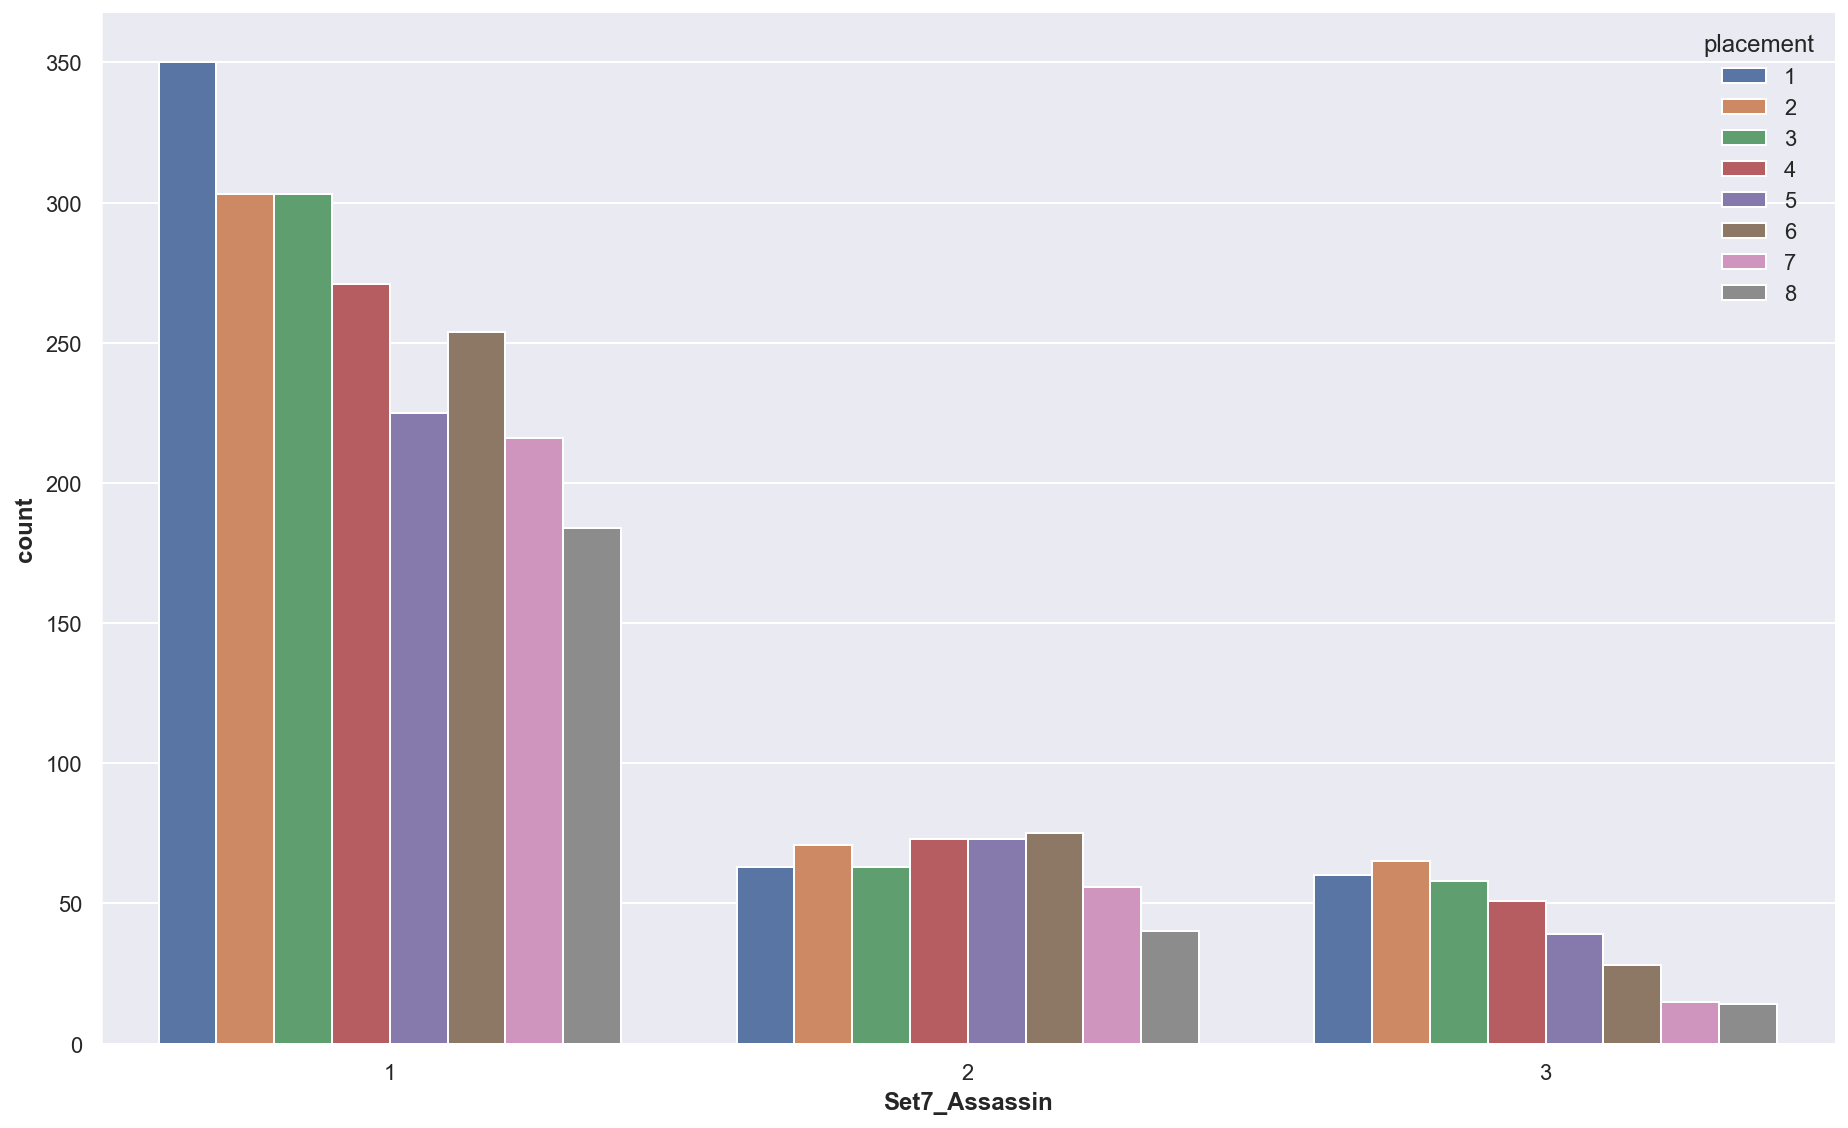

In [1195]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Assassin']>0], x='Set7_Assassin', hue=TARGETNAME)
sns.despine()

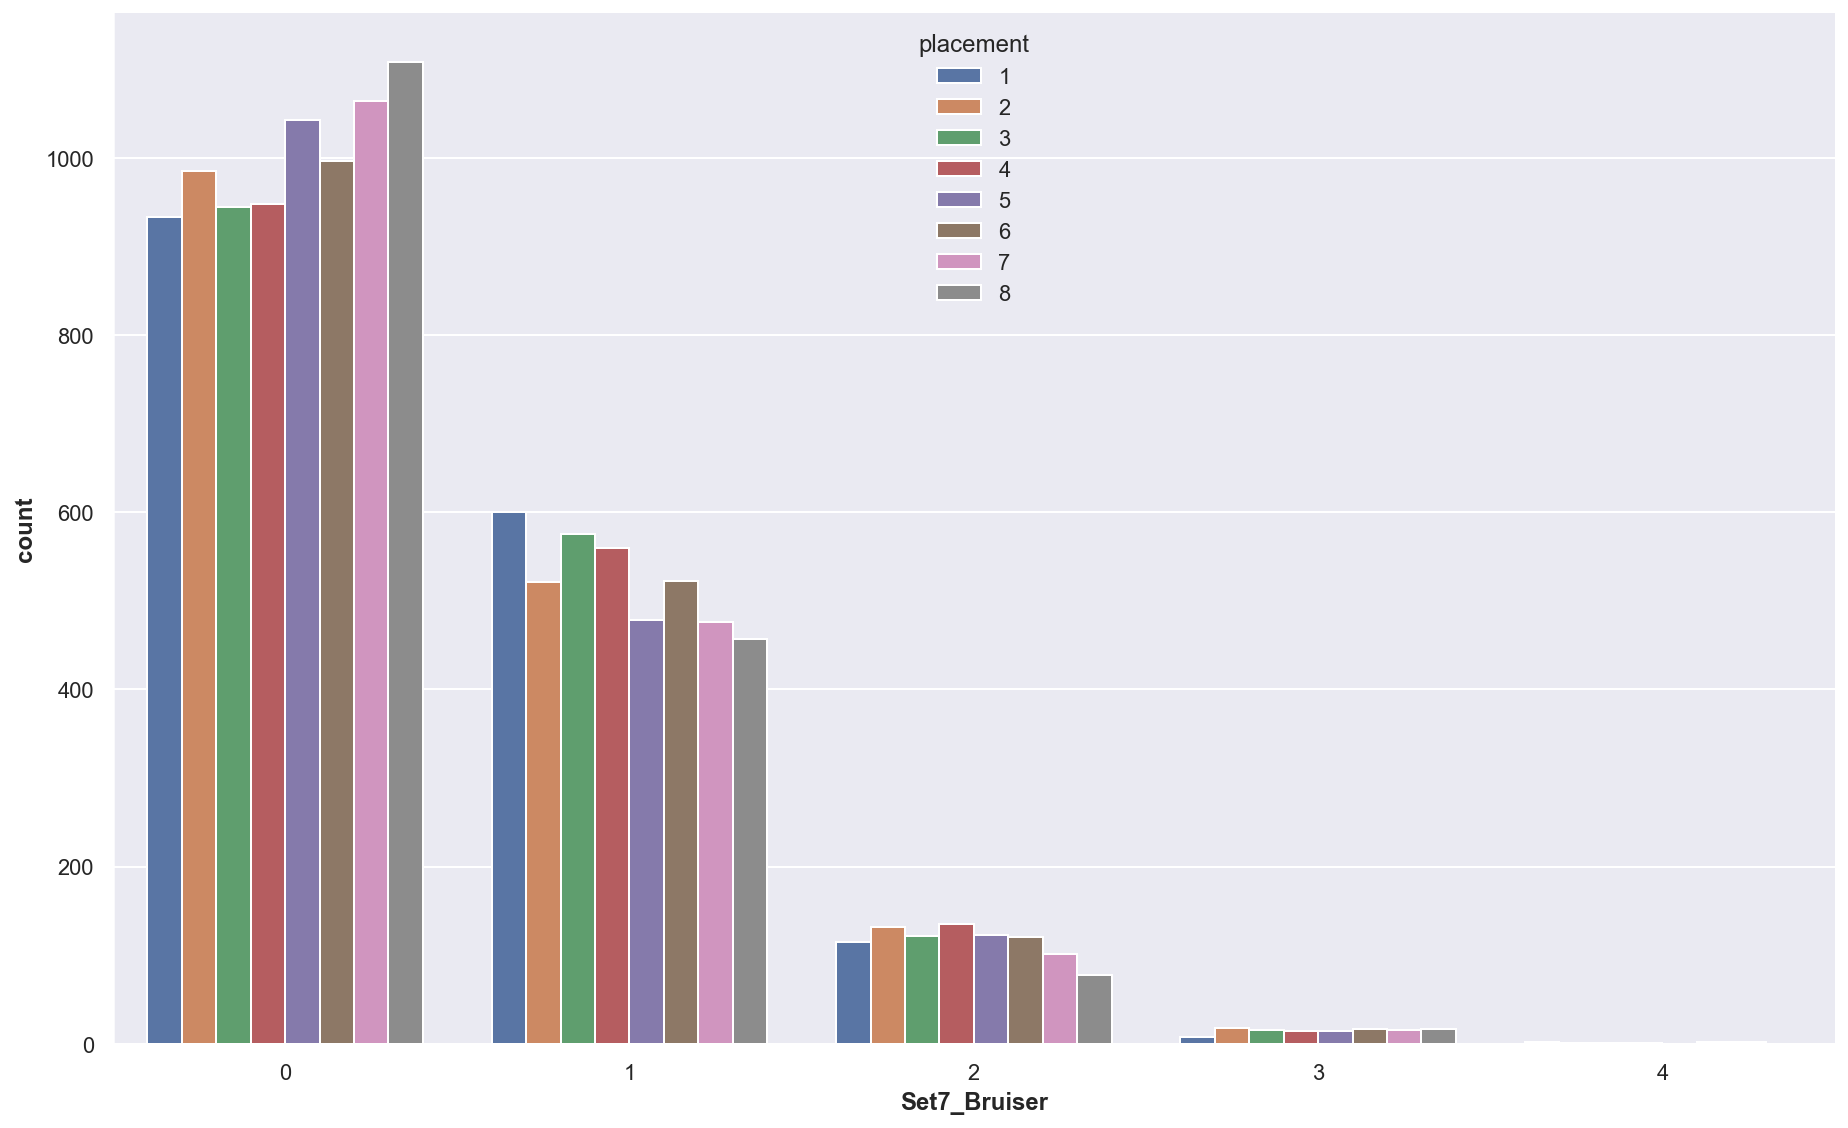

In [1196]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Bruiser']>=0], x='Set7_Bruiser', hue=TARGETNAME)
sns.despine()

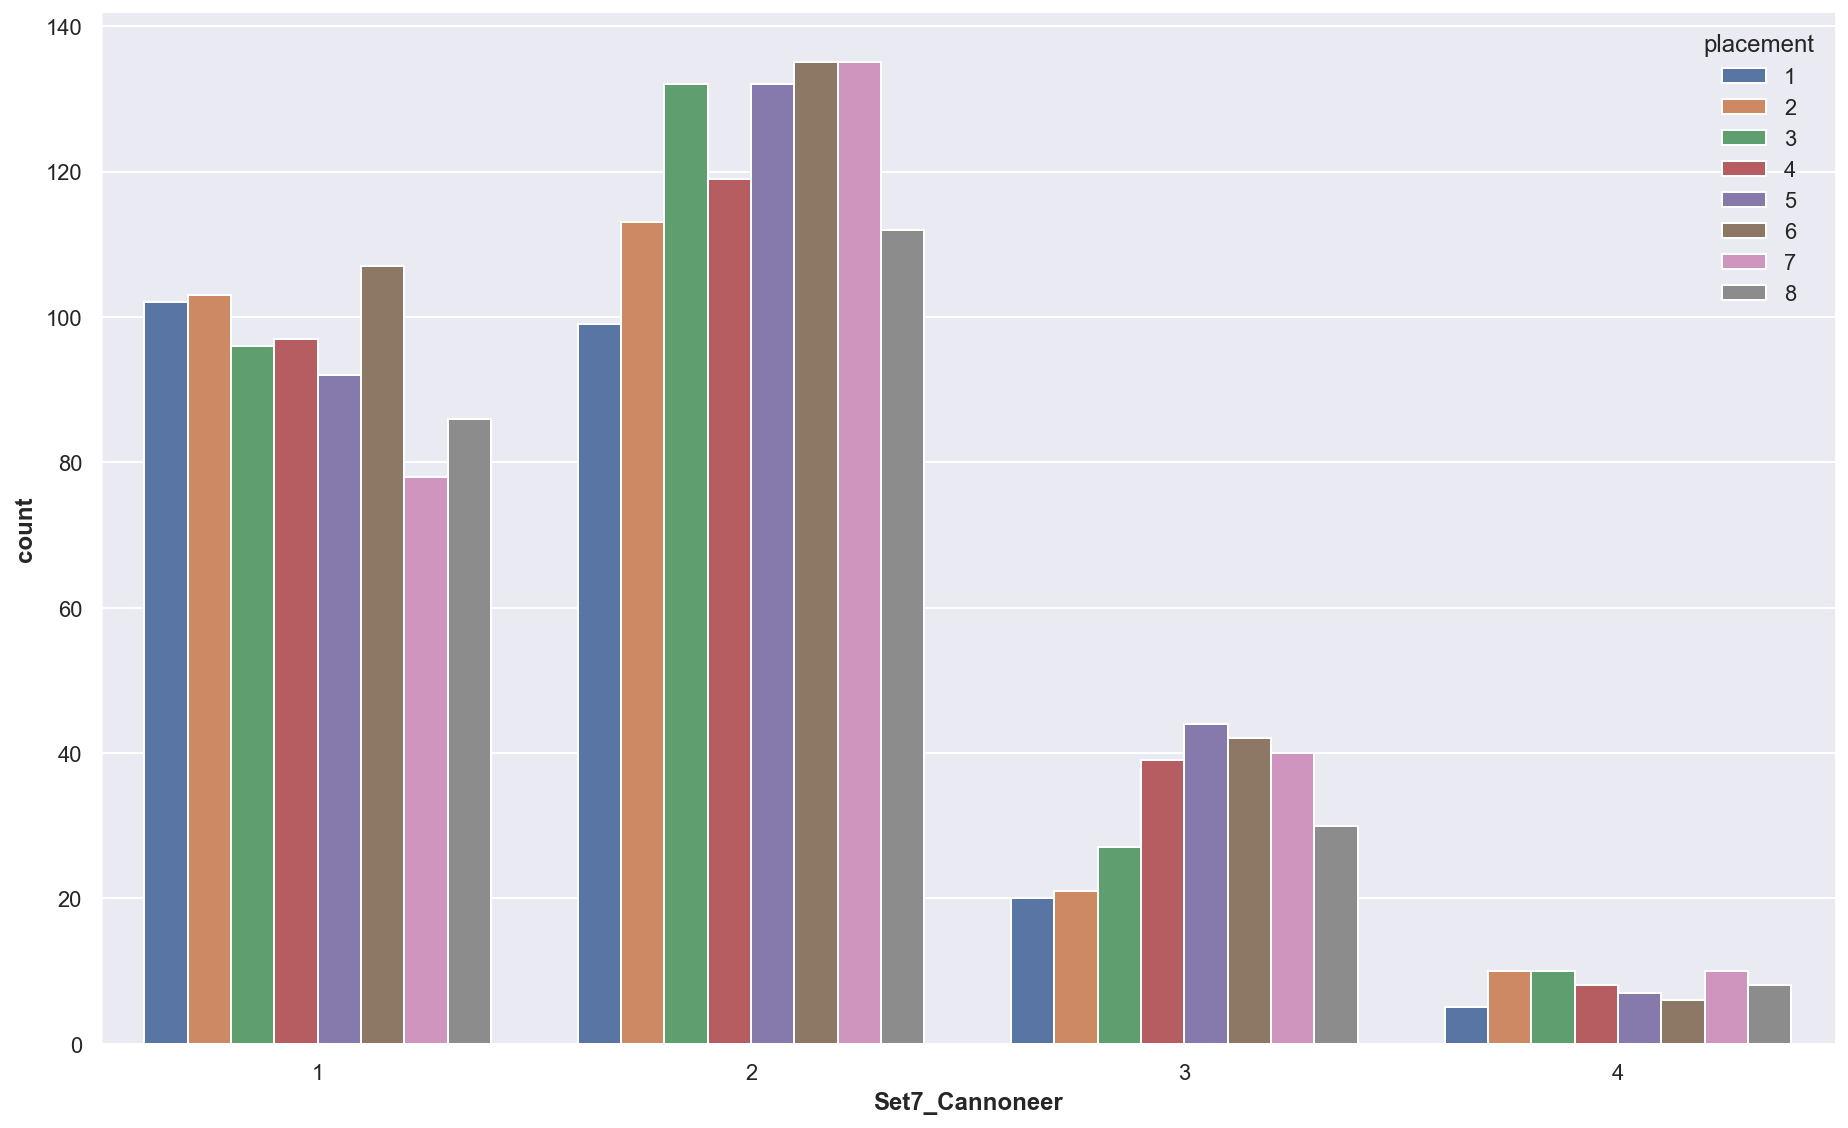

In [1197]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Cannoneer']>0], x='Set7_Cannoneer', hue=TARGETNAME)
sns.despine()

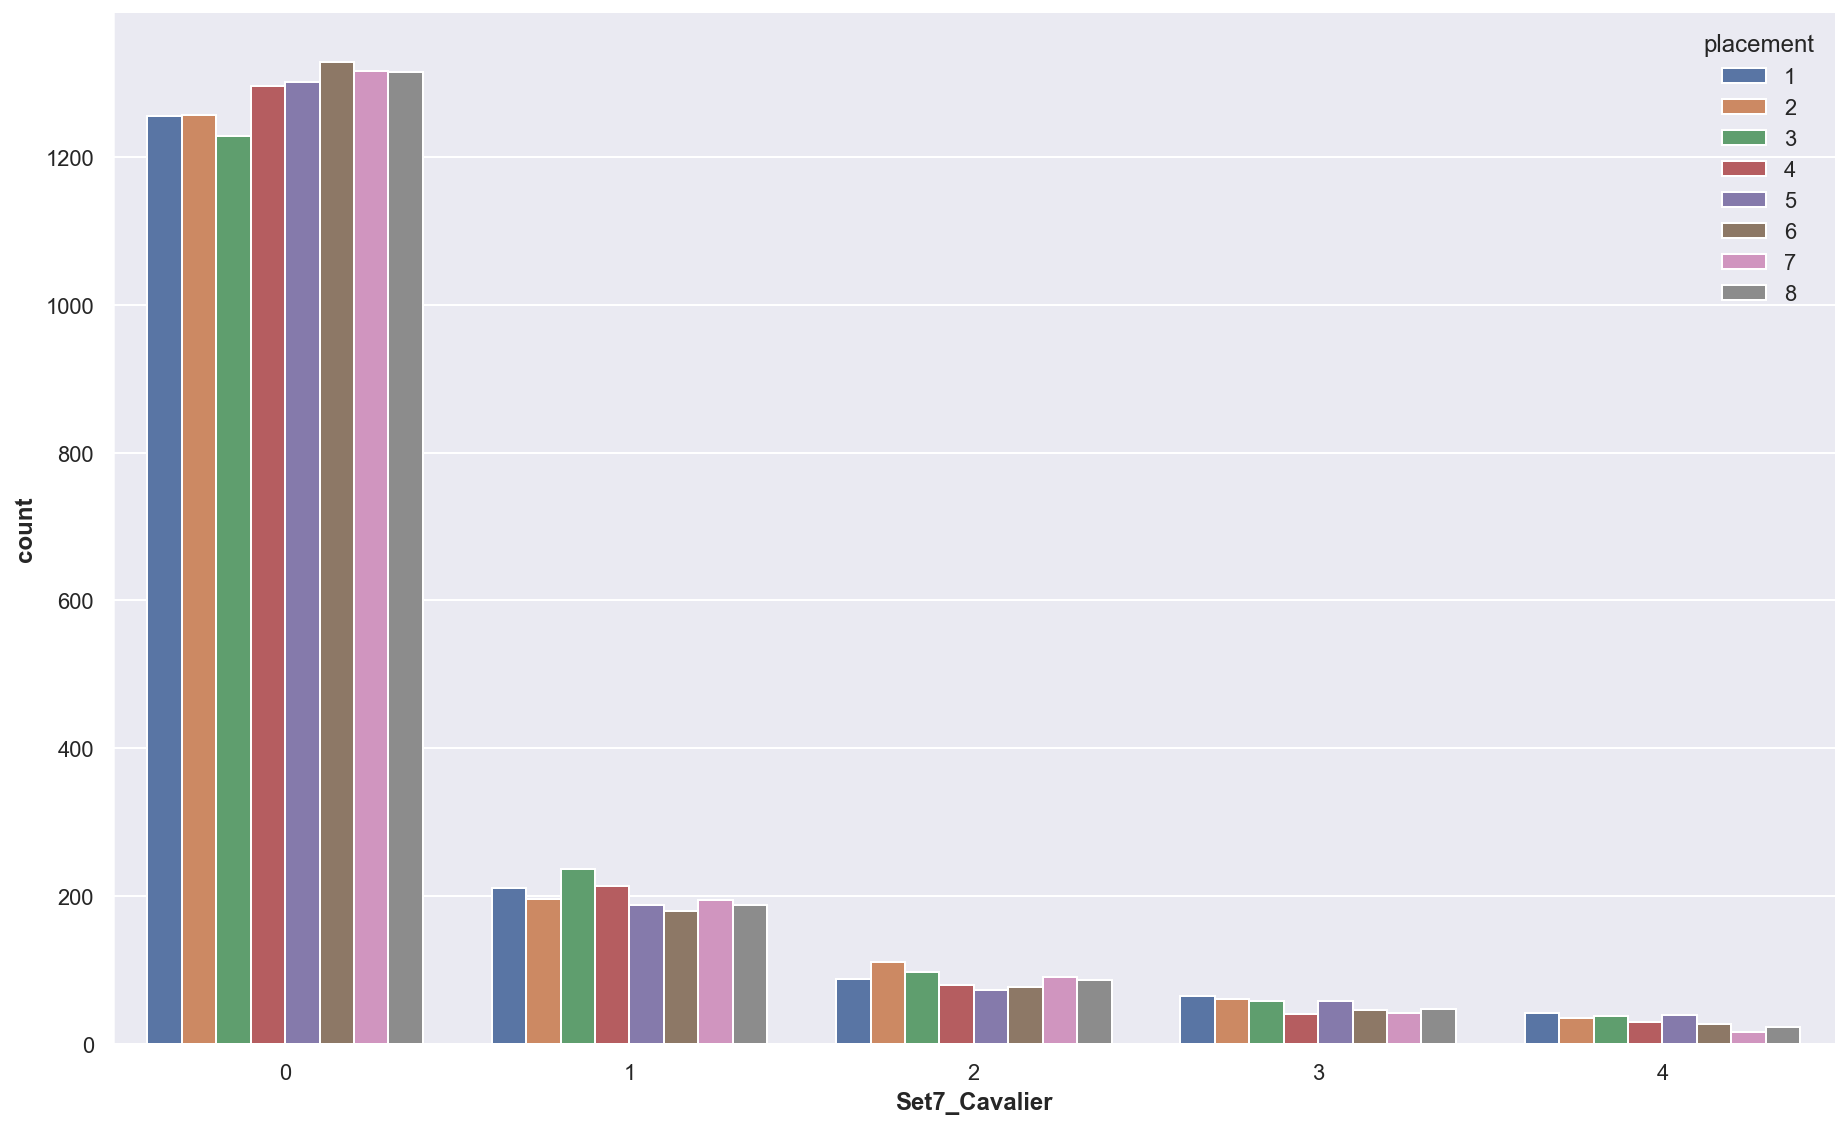

In [1198]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Cavalier']>=0], x='Set7_Cavalier', hue=TARGETNAME)
sns.despine()

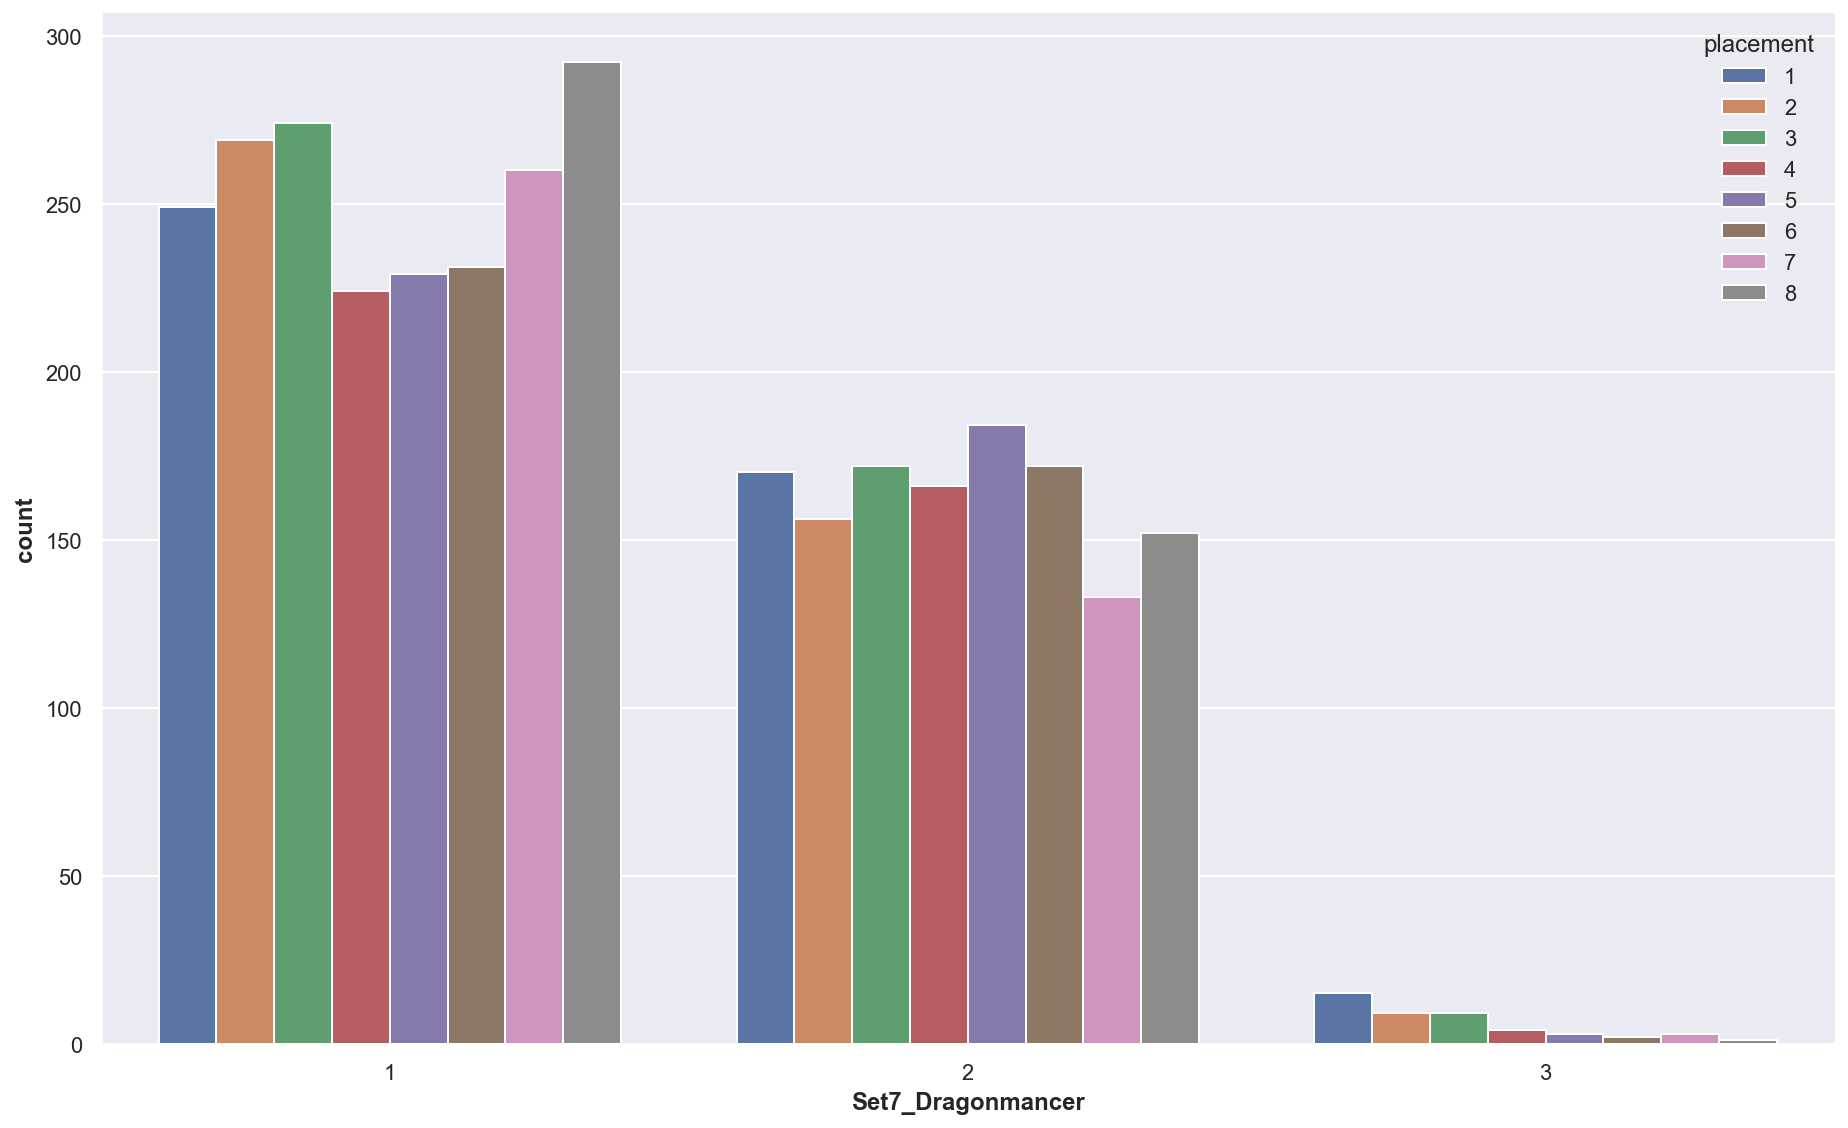

In [1199]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Dragonmancer']>0], x='Set7_Dragonmancer', hue=TARGETNAME)
sns.despine()

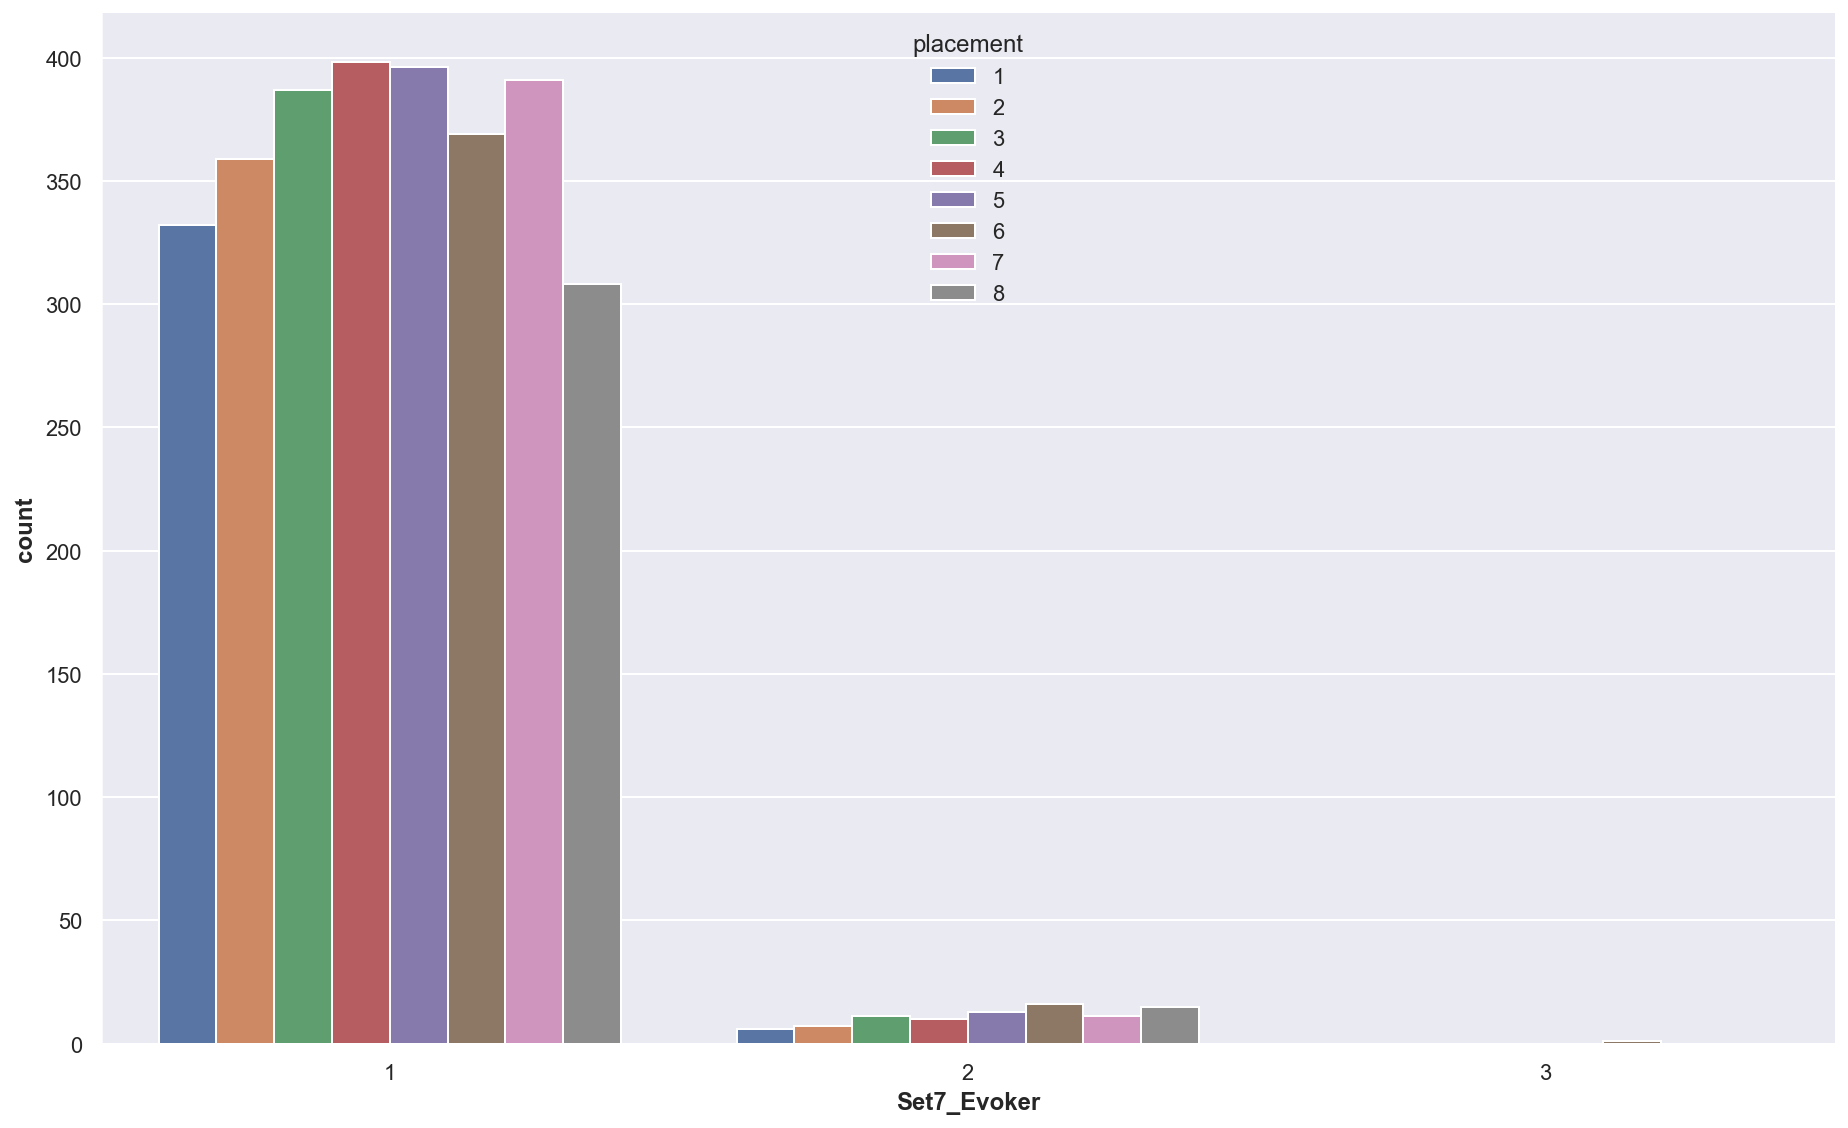

In [1200]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Evoker']>0], x='Set7_Evoker', hue=TARGETNAME)
sns.despine()

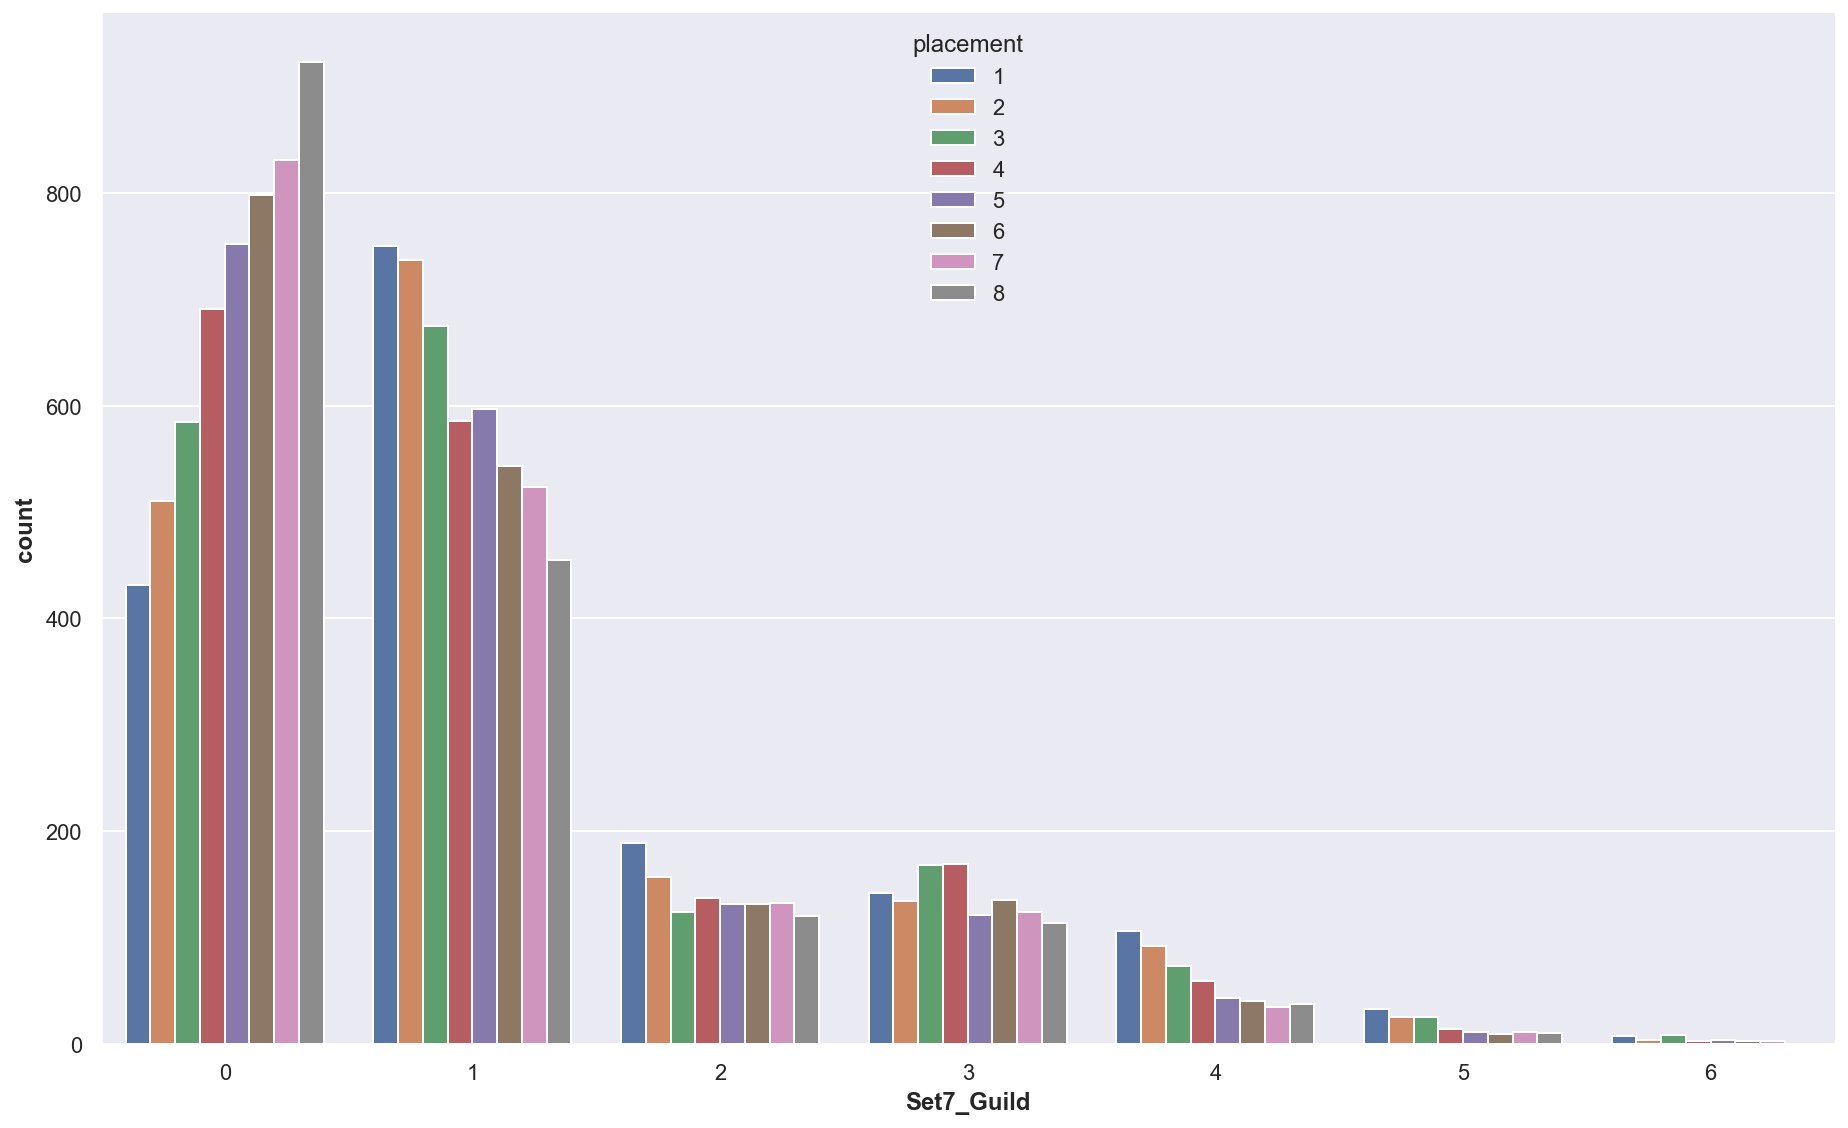

In [1201]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Guild', hue=TARGETNAME)
sns.despine()

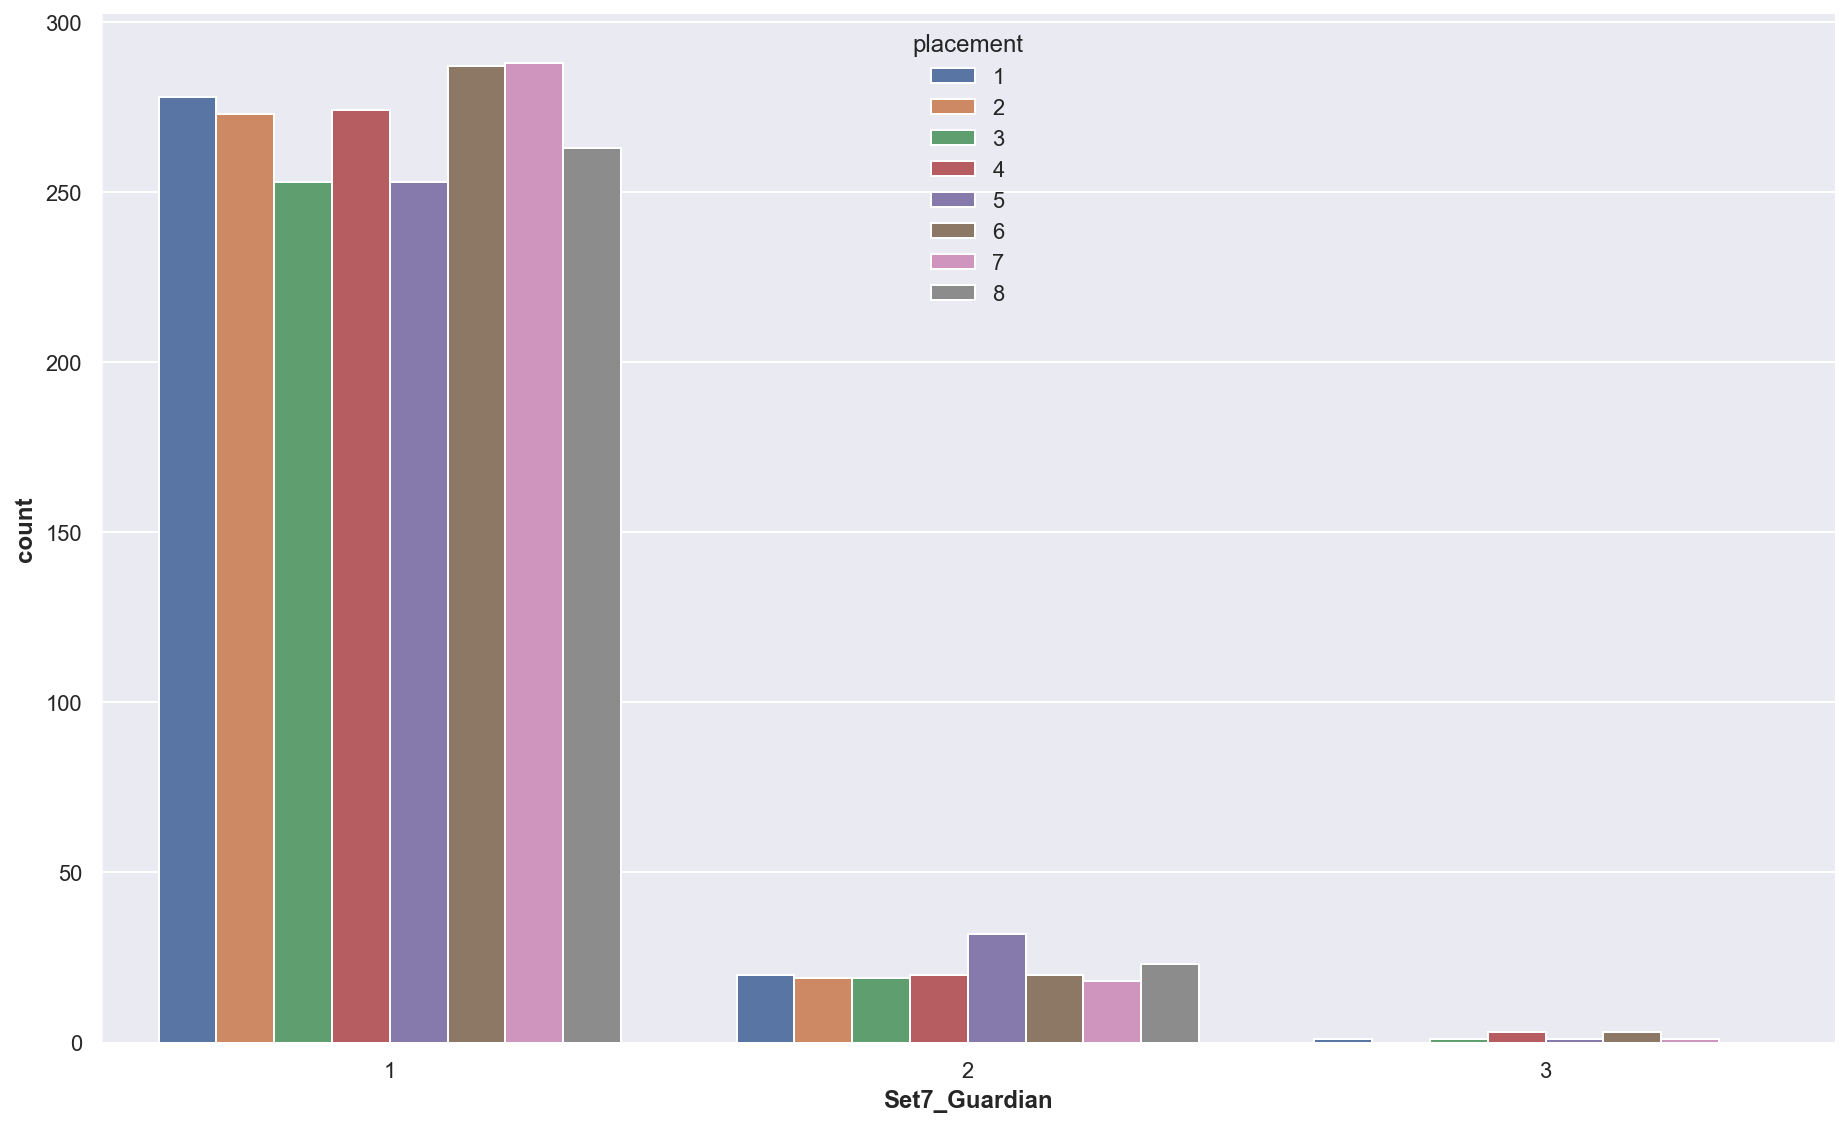

In [1202]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Guardian']>0], x='Set7_Guardian', hue=TARGETNAME)
sns.despine()

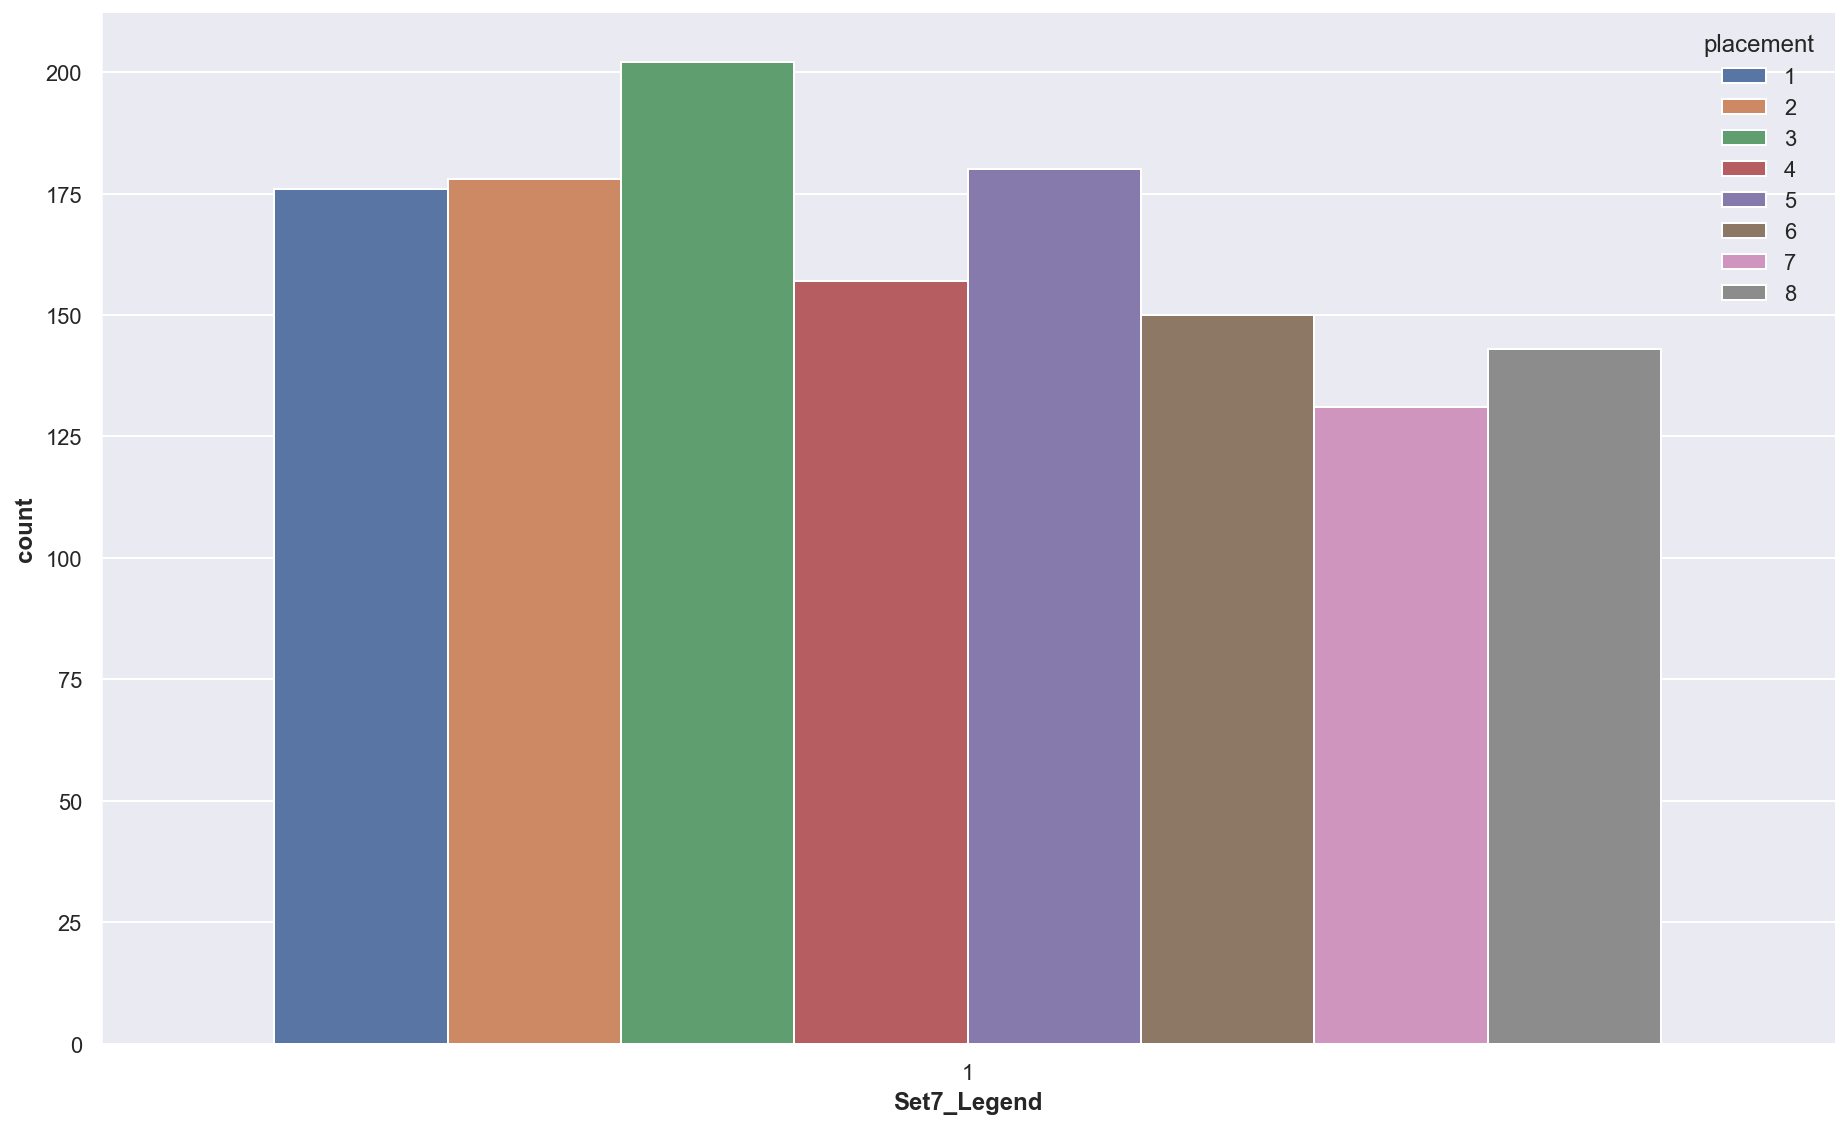

In [1203]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Legend']>0], x='Set7_Legend', hue=TARGETNAME)
sns.despine()

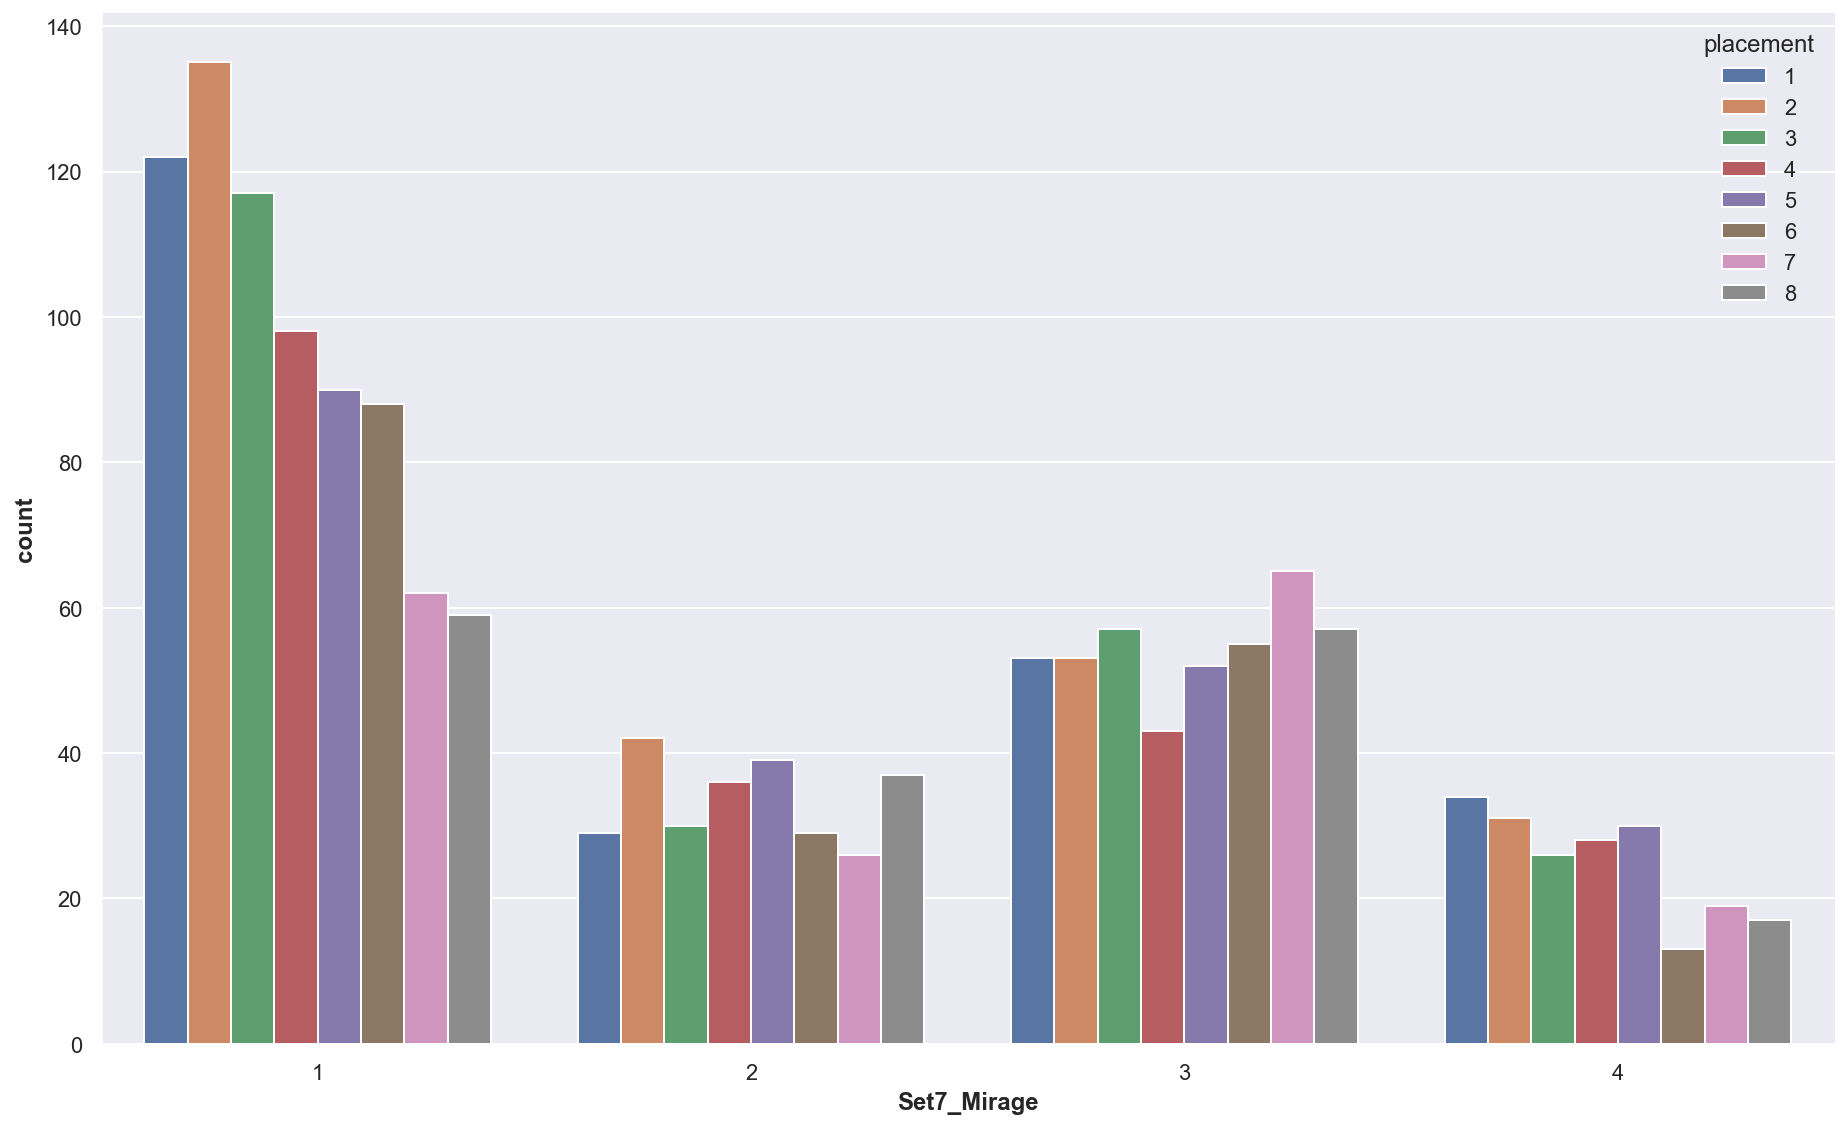

In [1204]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Mirage']>0], x='Set7_Mirage', hue=TARGETNAME)
sns.despine()

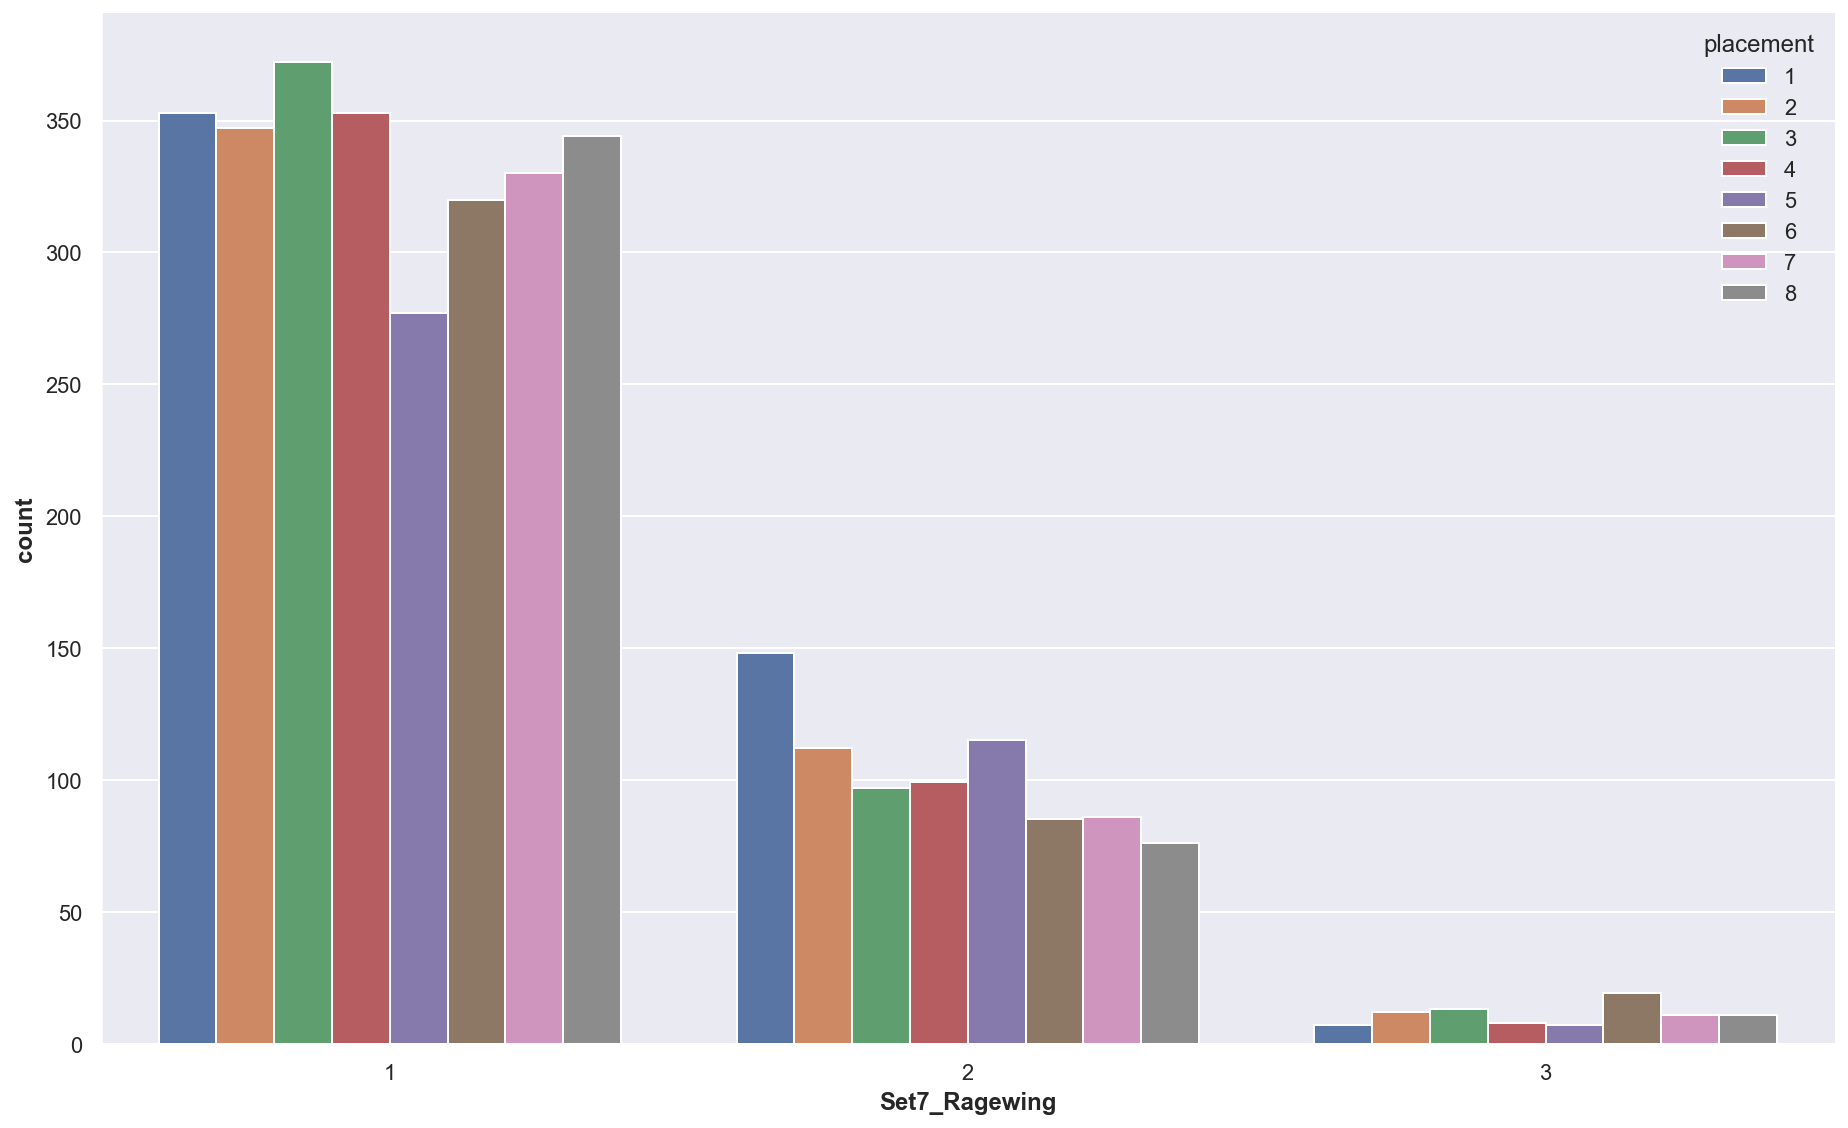

In [1205]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Ragewing']>0], x='Set7_Ragewing', hue=TARGETNAME)
sns.despine()

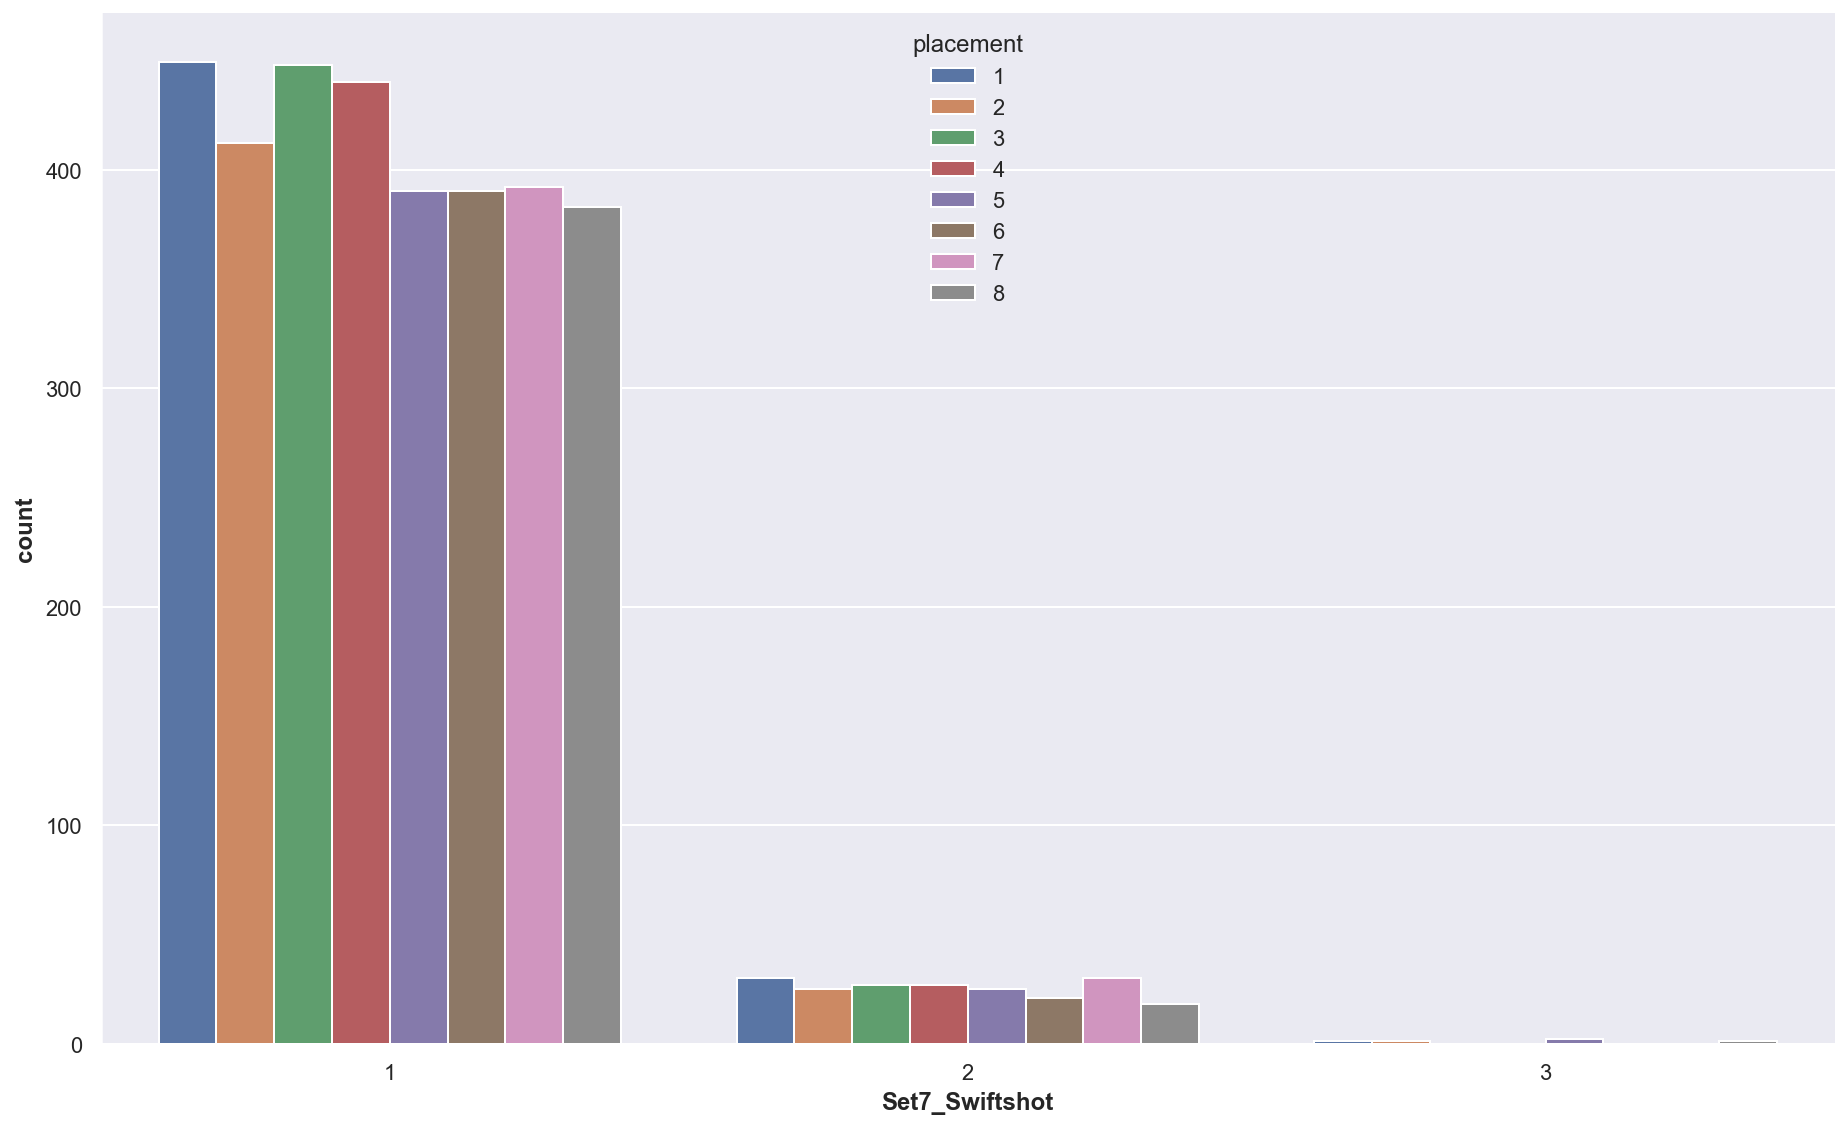

In [1206]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Swiftshot']>0], x='Set7_Swiftshot', hue=TARGETNAME)
sns.despine()

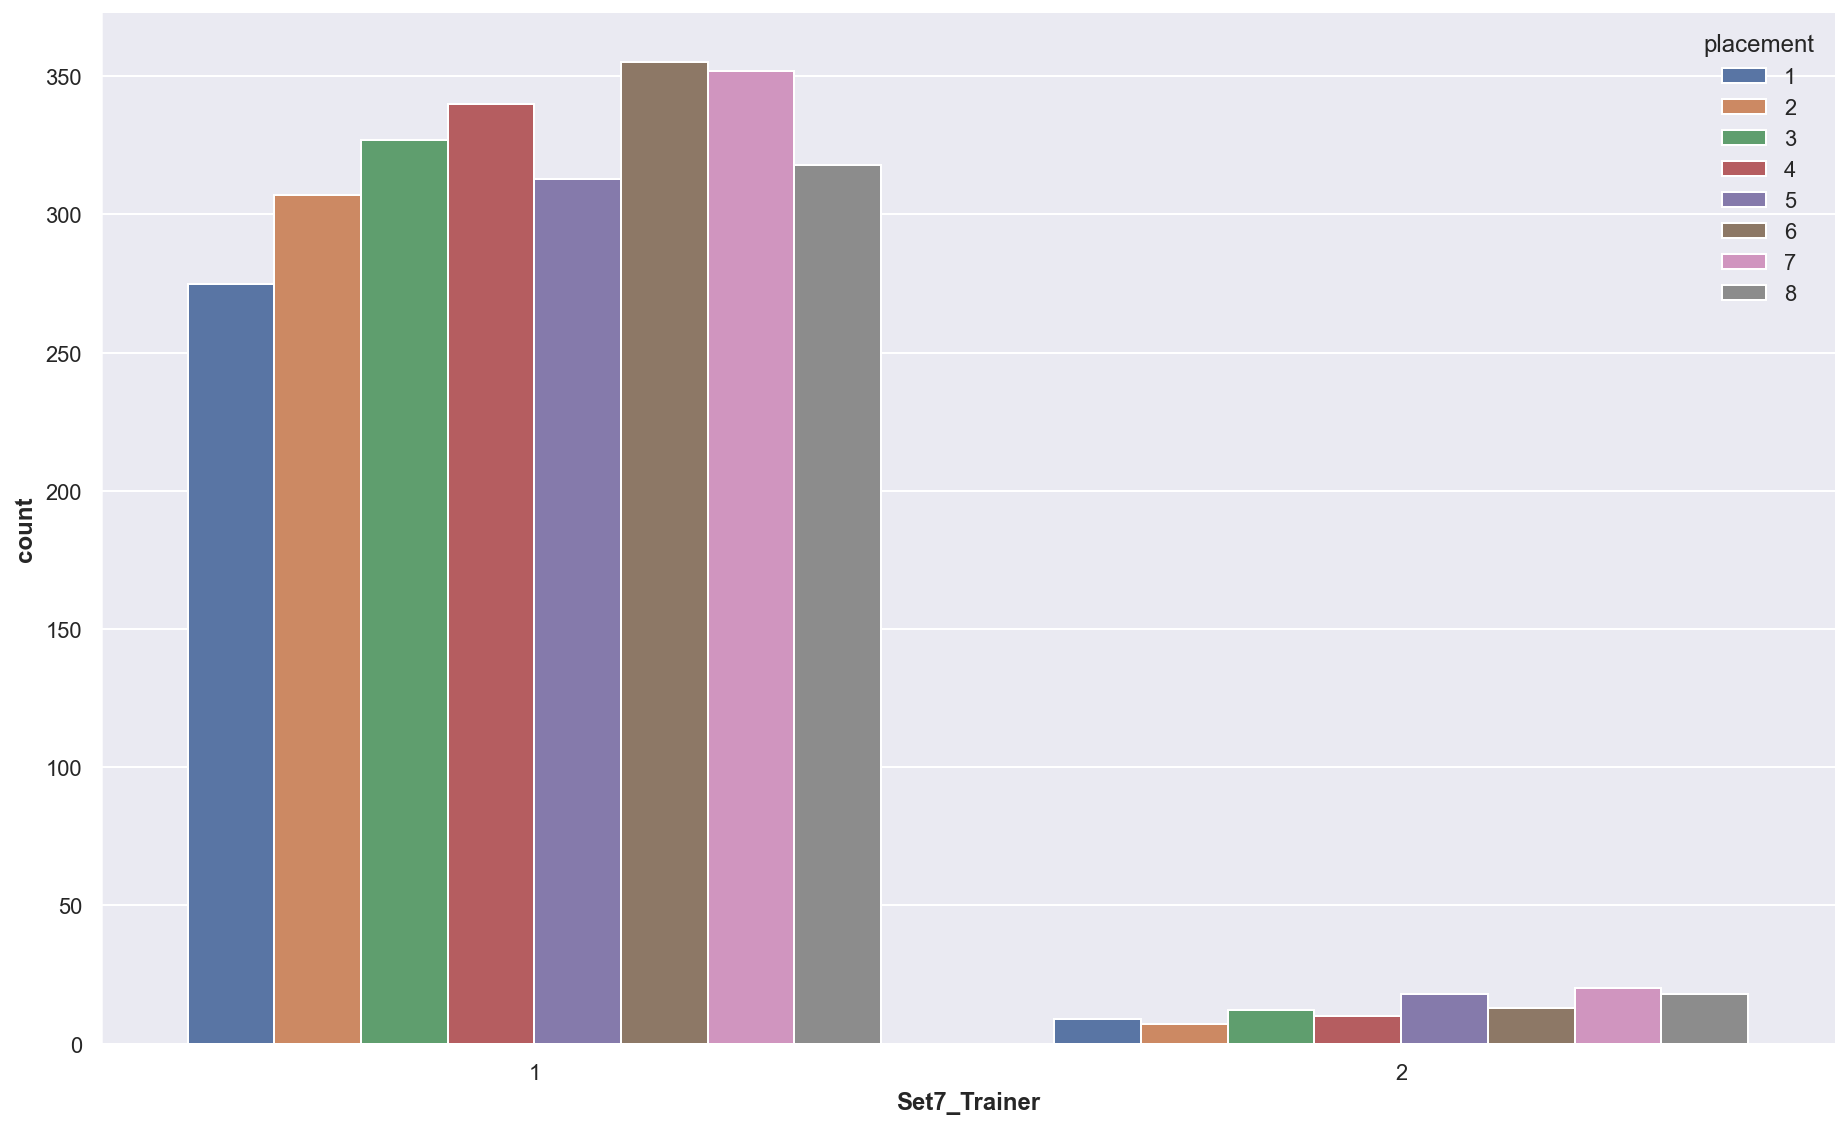

In [1207]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Trainer']>0], x='Set7_Trainer', hue=TARGETNAME)
sns.despine()

This trait show the highest correlation in placement.

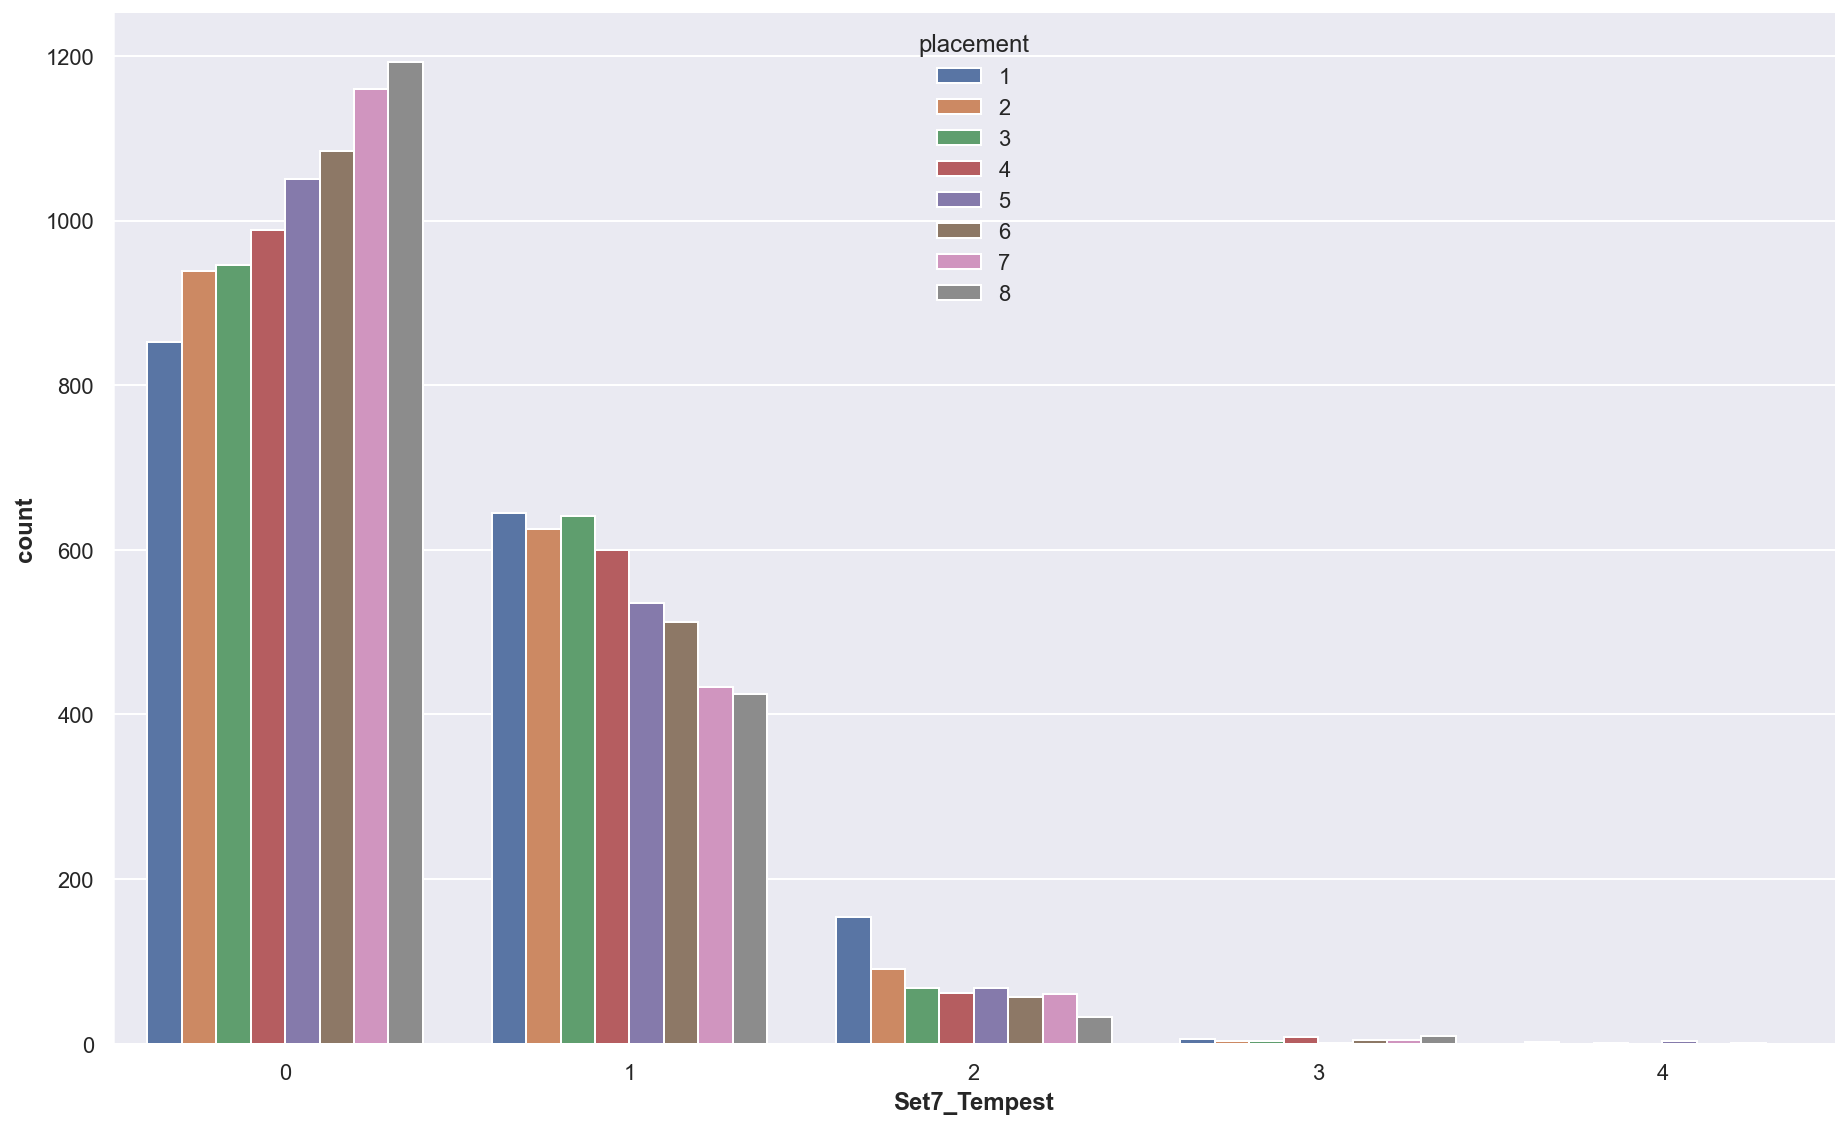

In [1208]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Tempest']>=0], x='Set7_Tempest', hue=TARGETNAME)
sns.despine()

Stronger correlation at trait lvl 1.

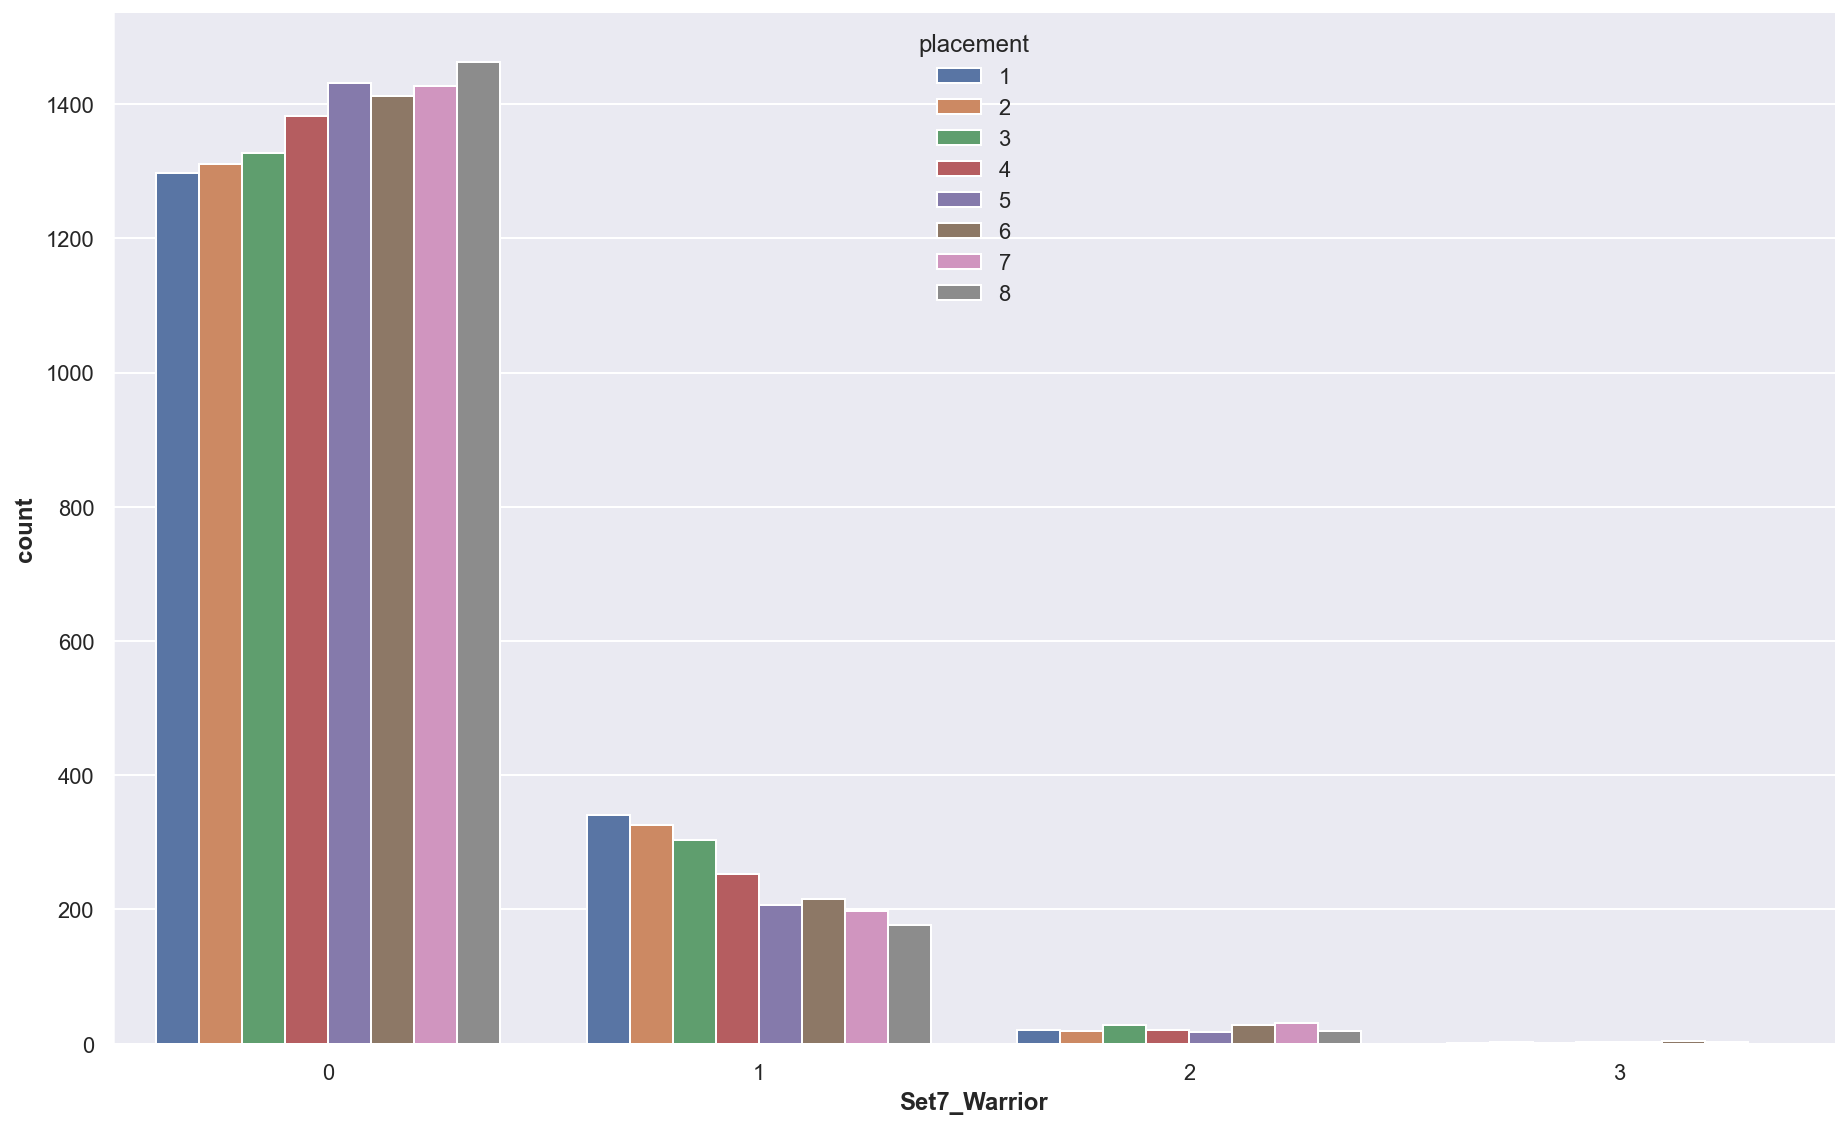

In [1209]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Warrior']>=0], x='Set7_Warrior', hue=TARGETNAME)
sns.despine()

# Units

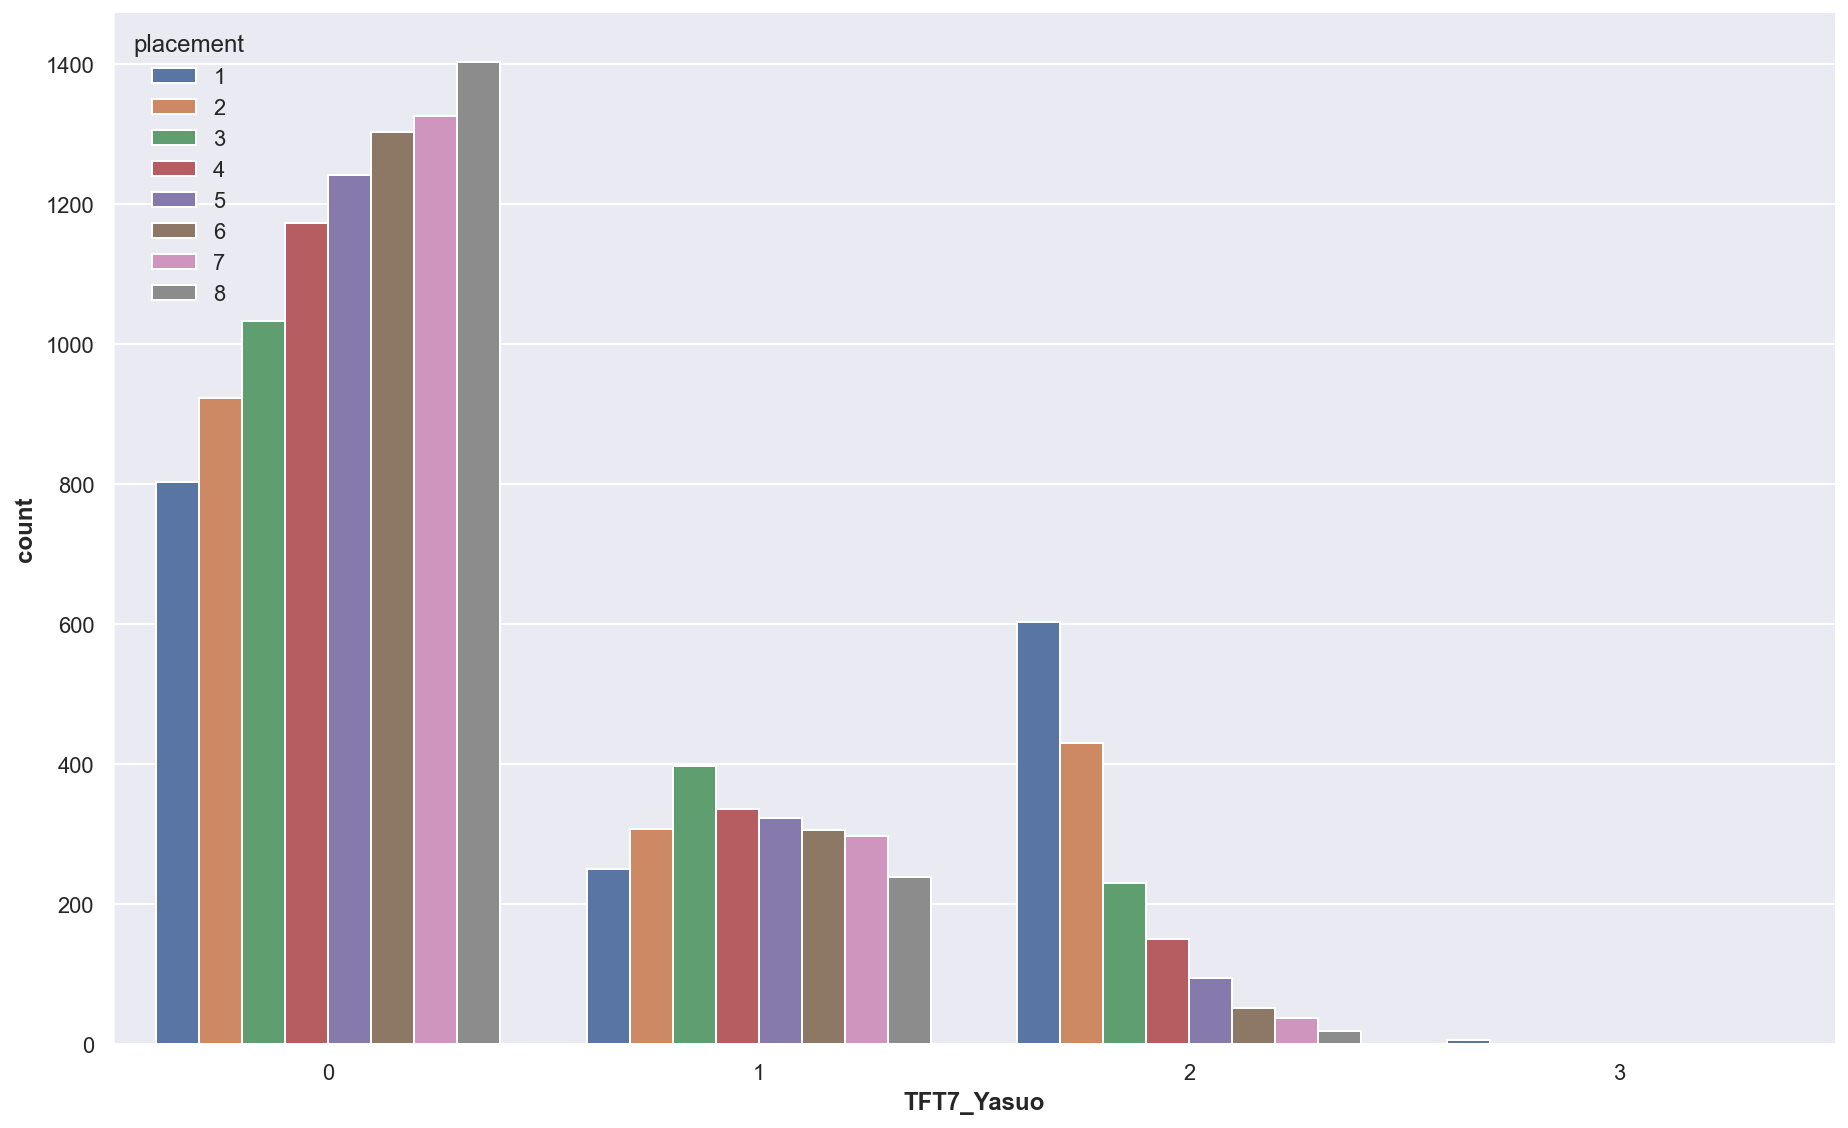

In [1210]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Yasuo', hue=TARGETNAME)
sns.despine()

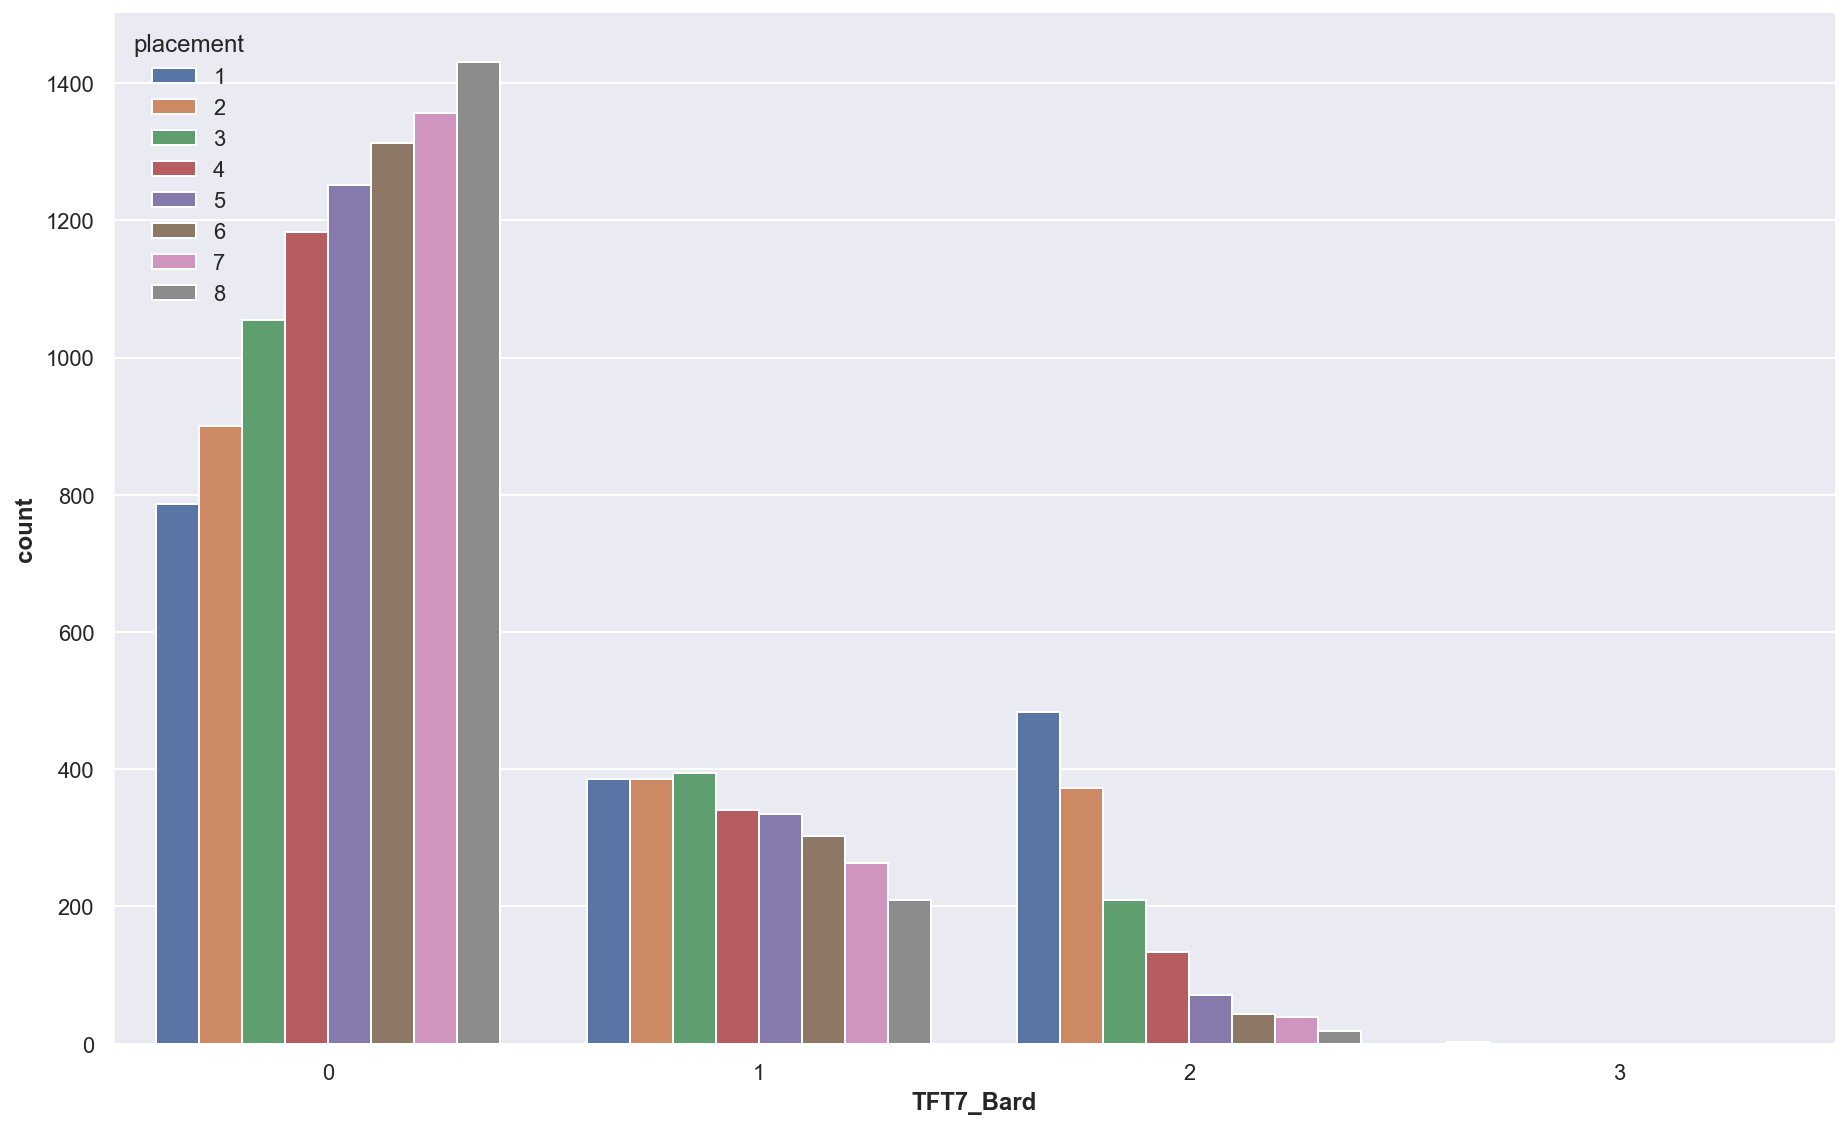

In [1211]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Bard', hue=TARGETNAME)
sns.despine()

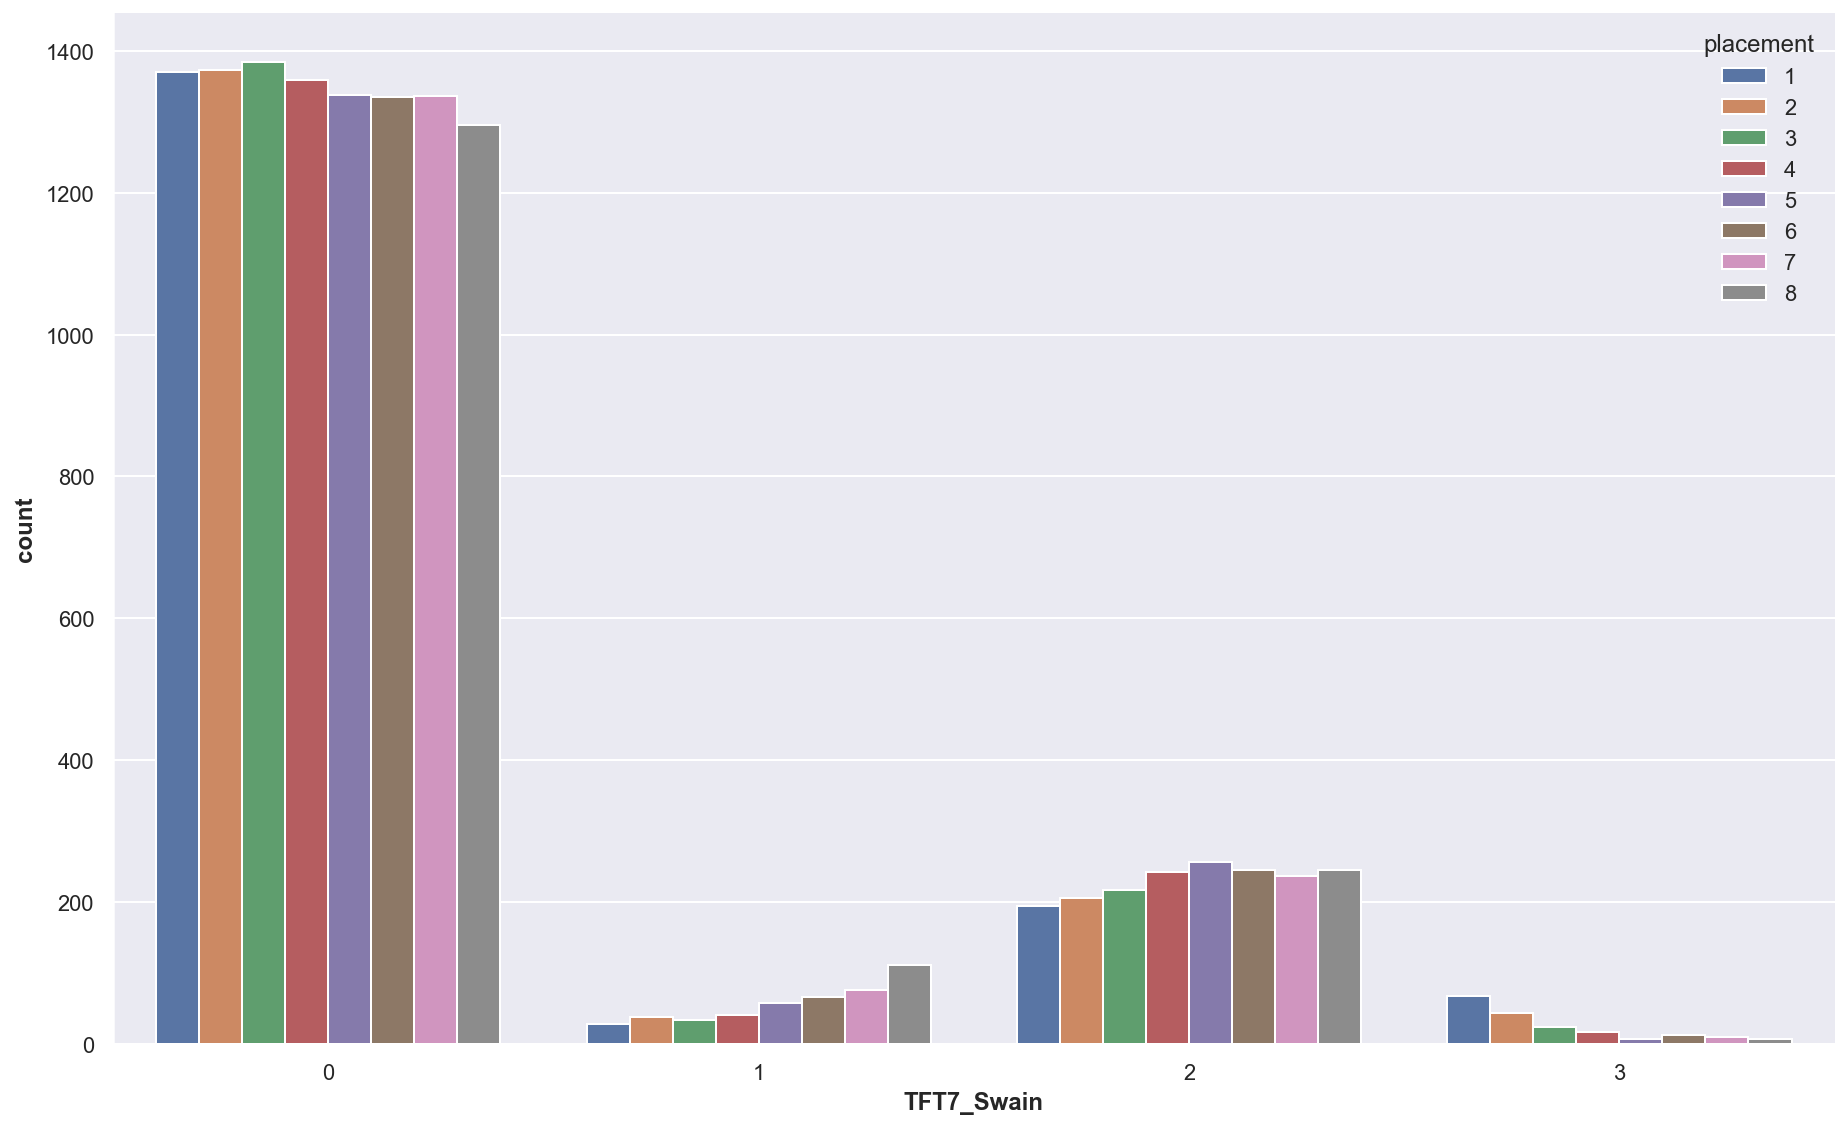

In [1212]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Swain', hue=TARGETNAME)
sns.despine()

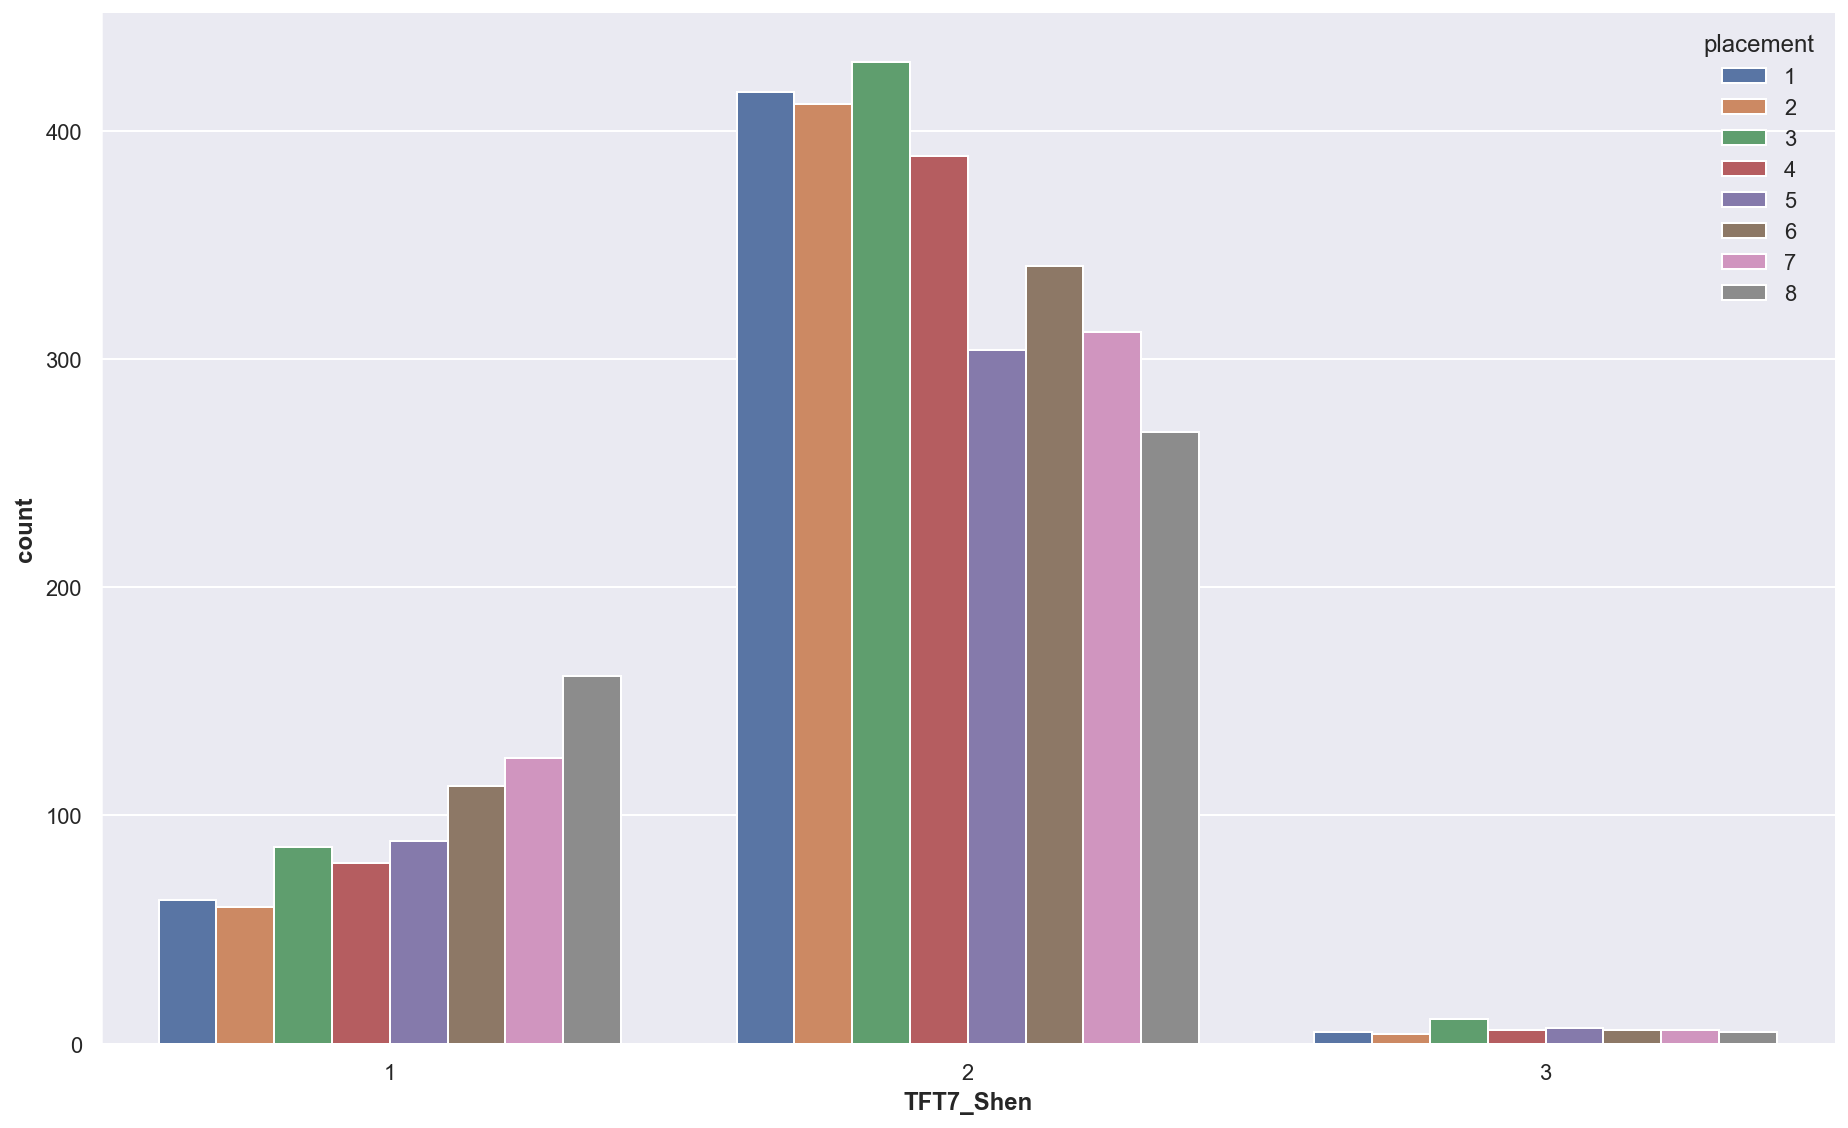

In [1213]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Shen']>0], x='TFT7_Shen', hue=TARGETNAME)
sns.despine()

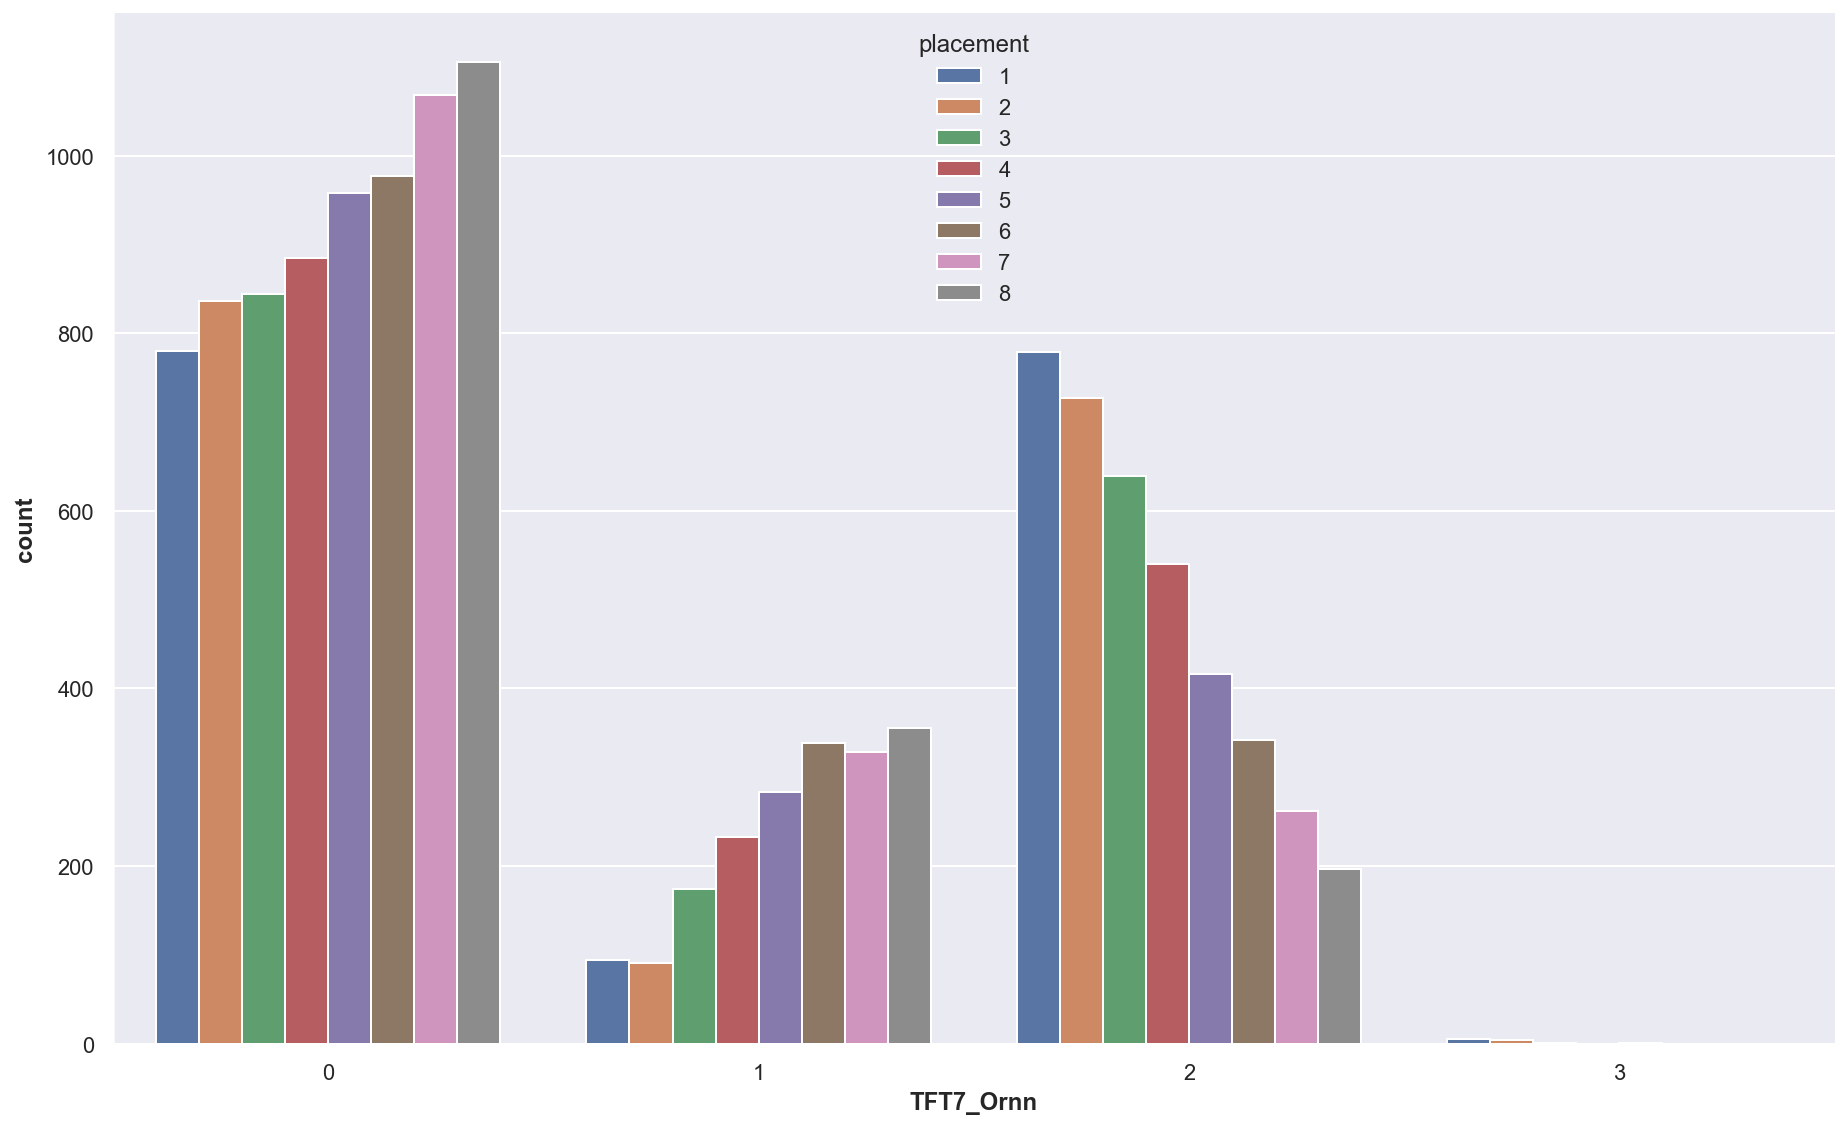

In [1214]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Ornn']>=0], x='TFT7_Ornn', hue=TARGETNAME)
sns.despine()

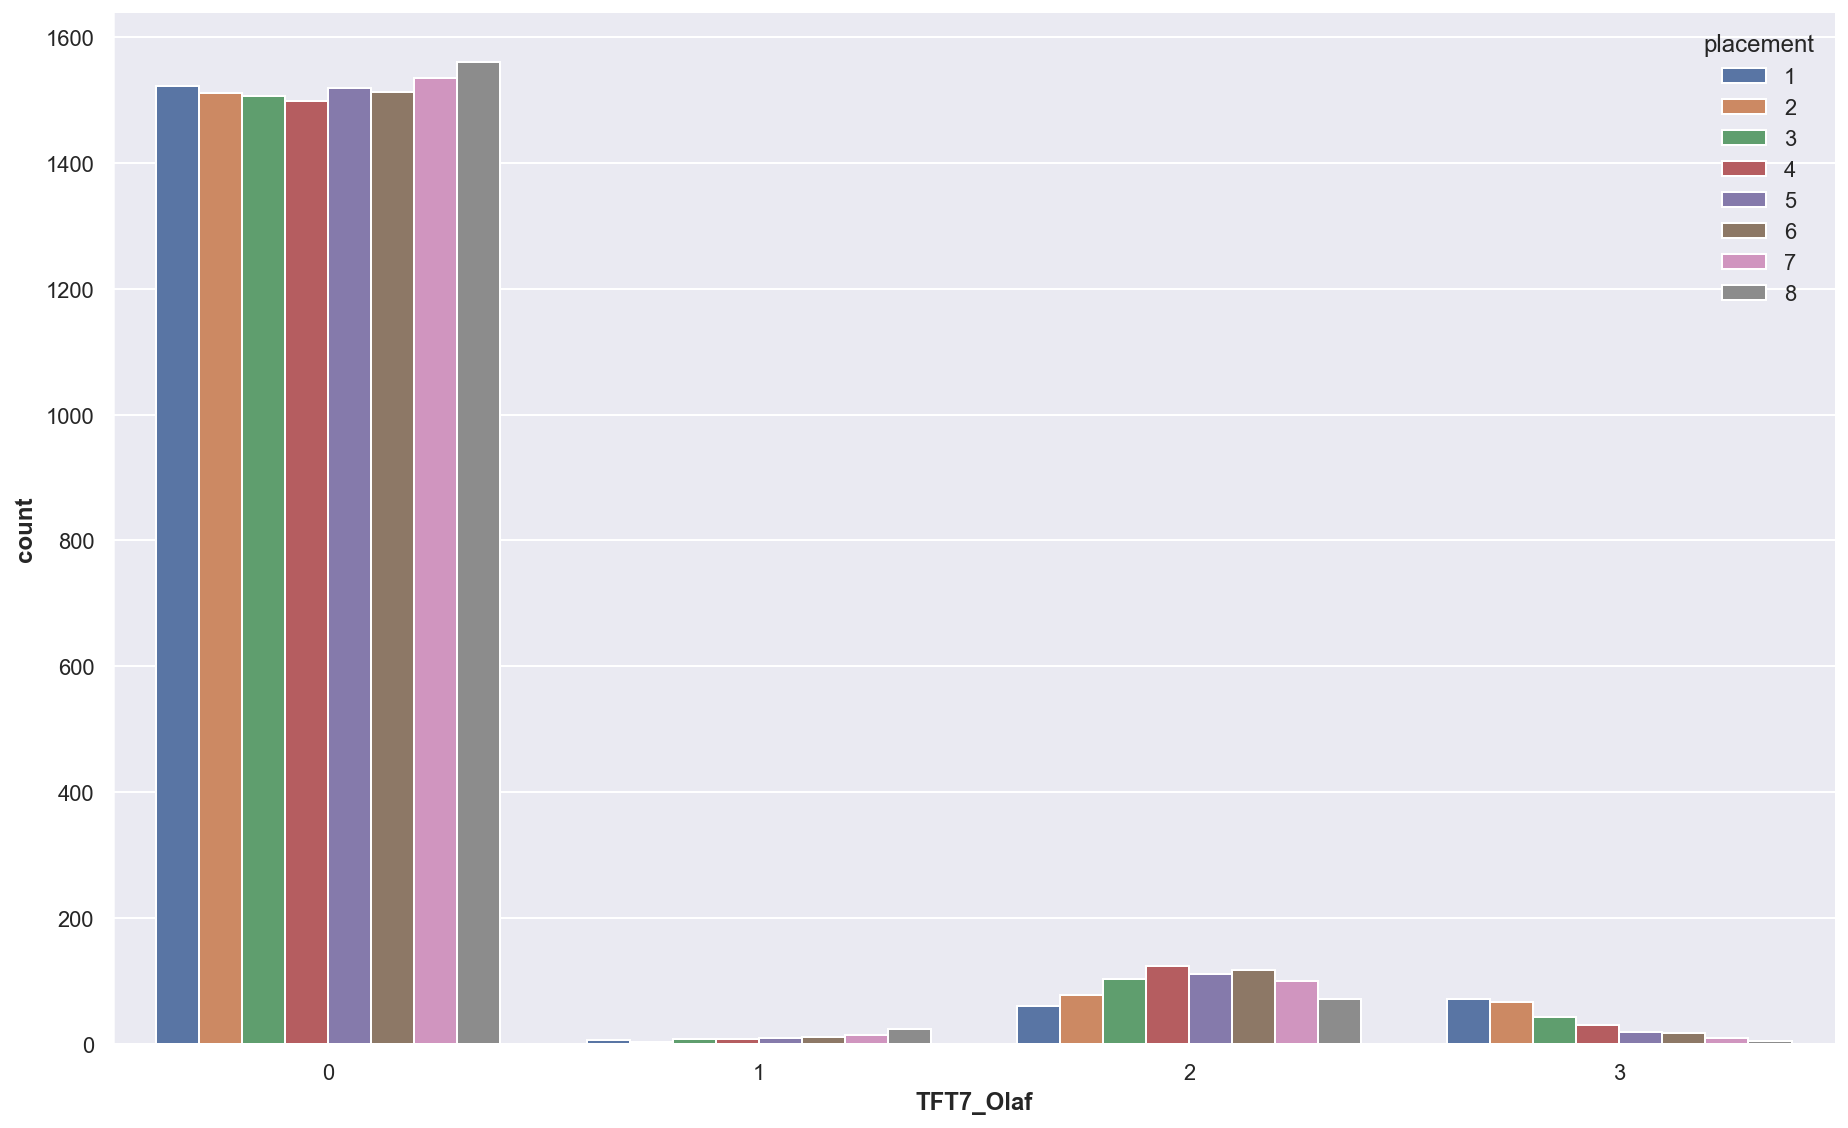

In [1215]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Olaf']>=0], x='TFT7_Olaf', hue=TARGETNAME)
sns.despine()

Synergy between units

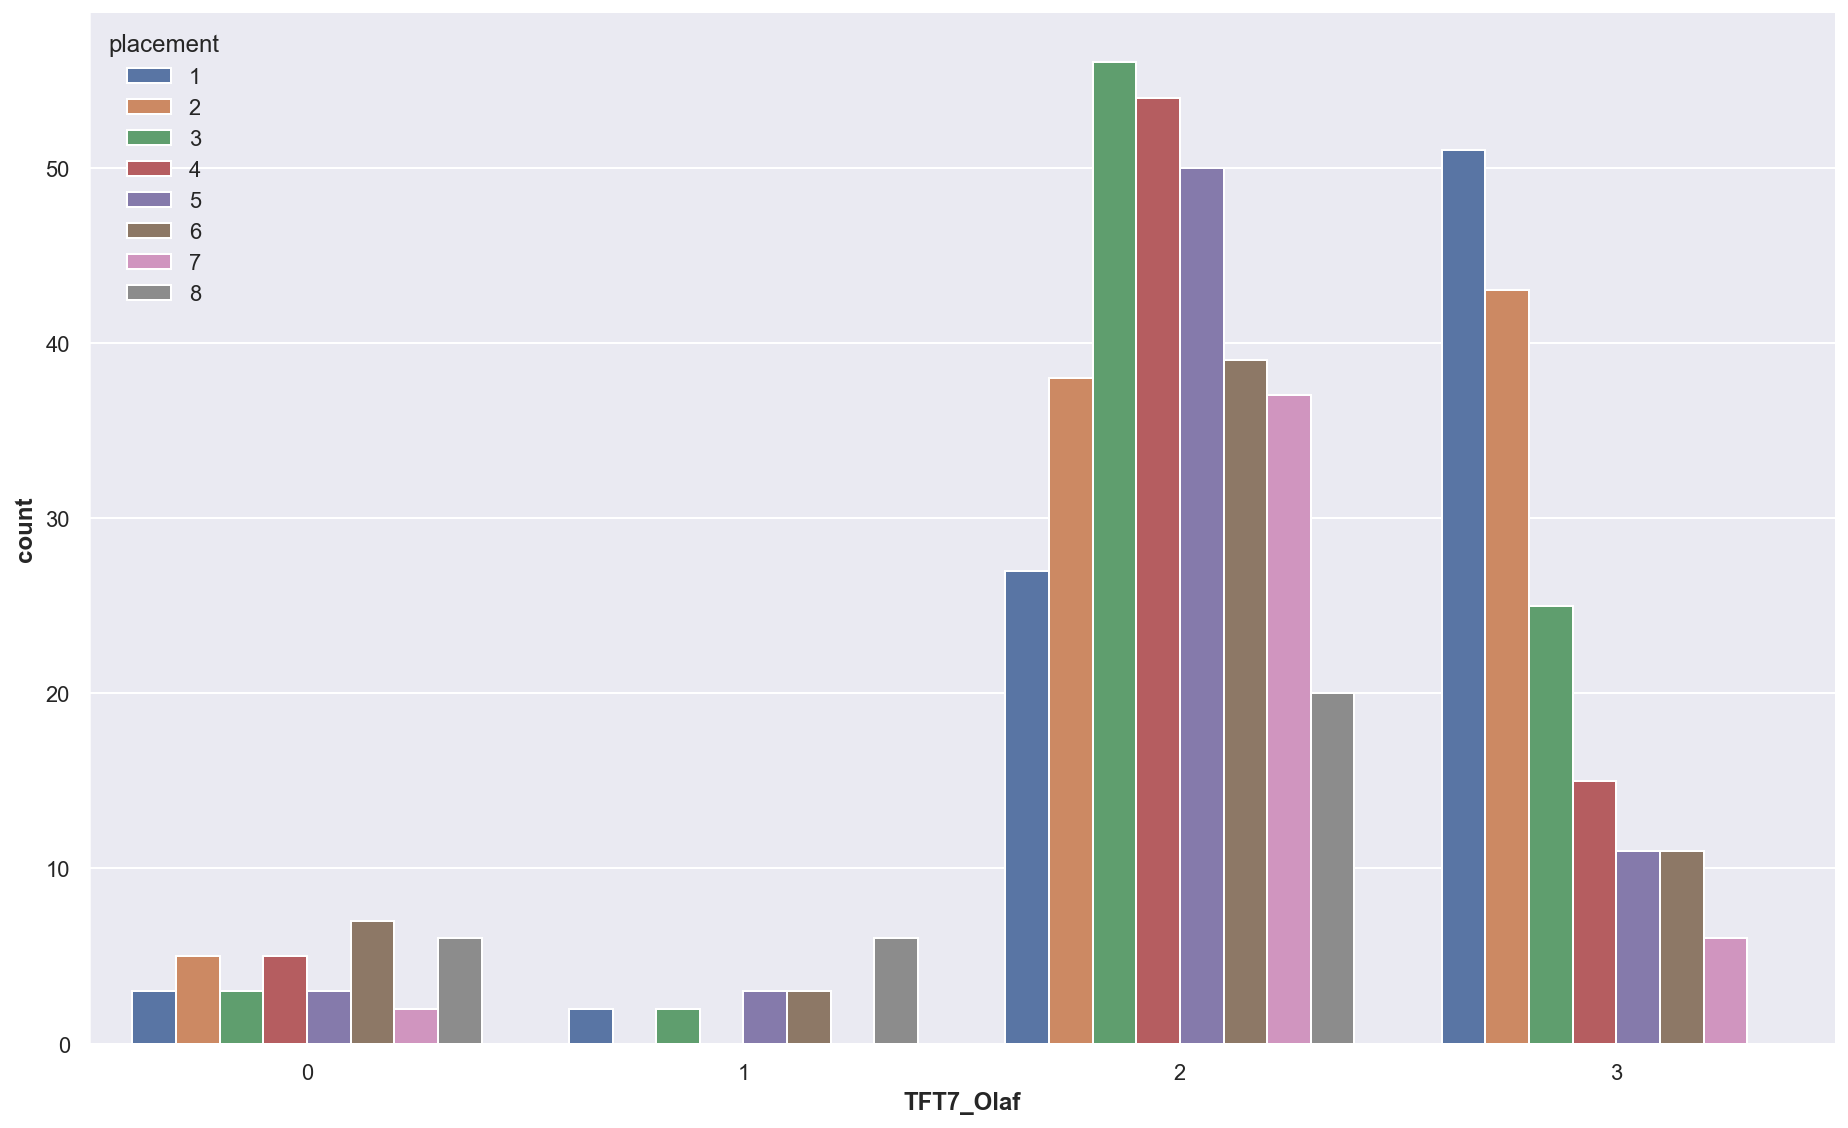

In [1216]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[(matches_df['TFT7_Shen']>1) & (matches_df['TFT7_Diana']>1)], x='TFT7_Olaf', hue=TARGETNAME)
sns.despine()

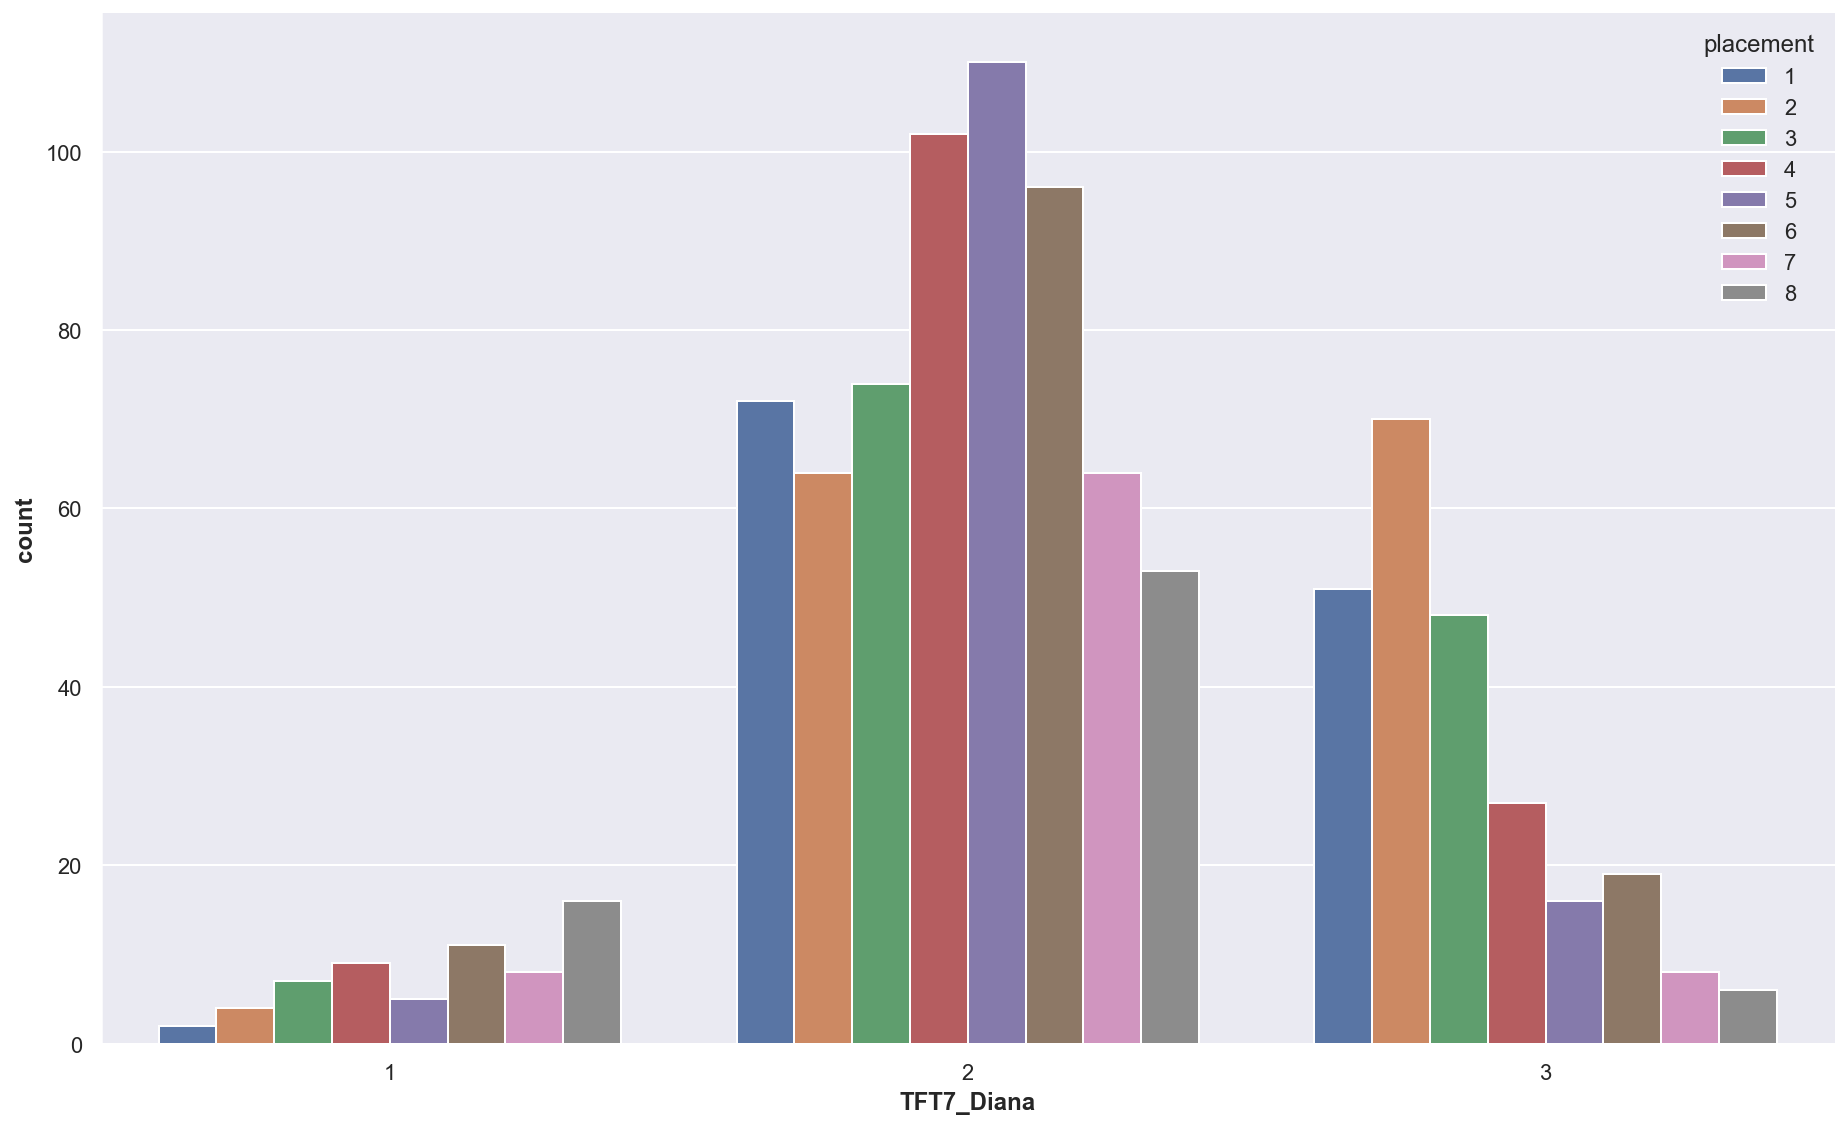

In [1217]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Diana']>0], x='TFT7_Diana', hue=TARGETNAME)
sns.despine()

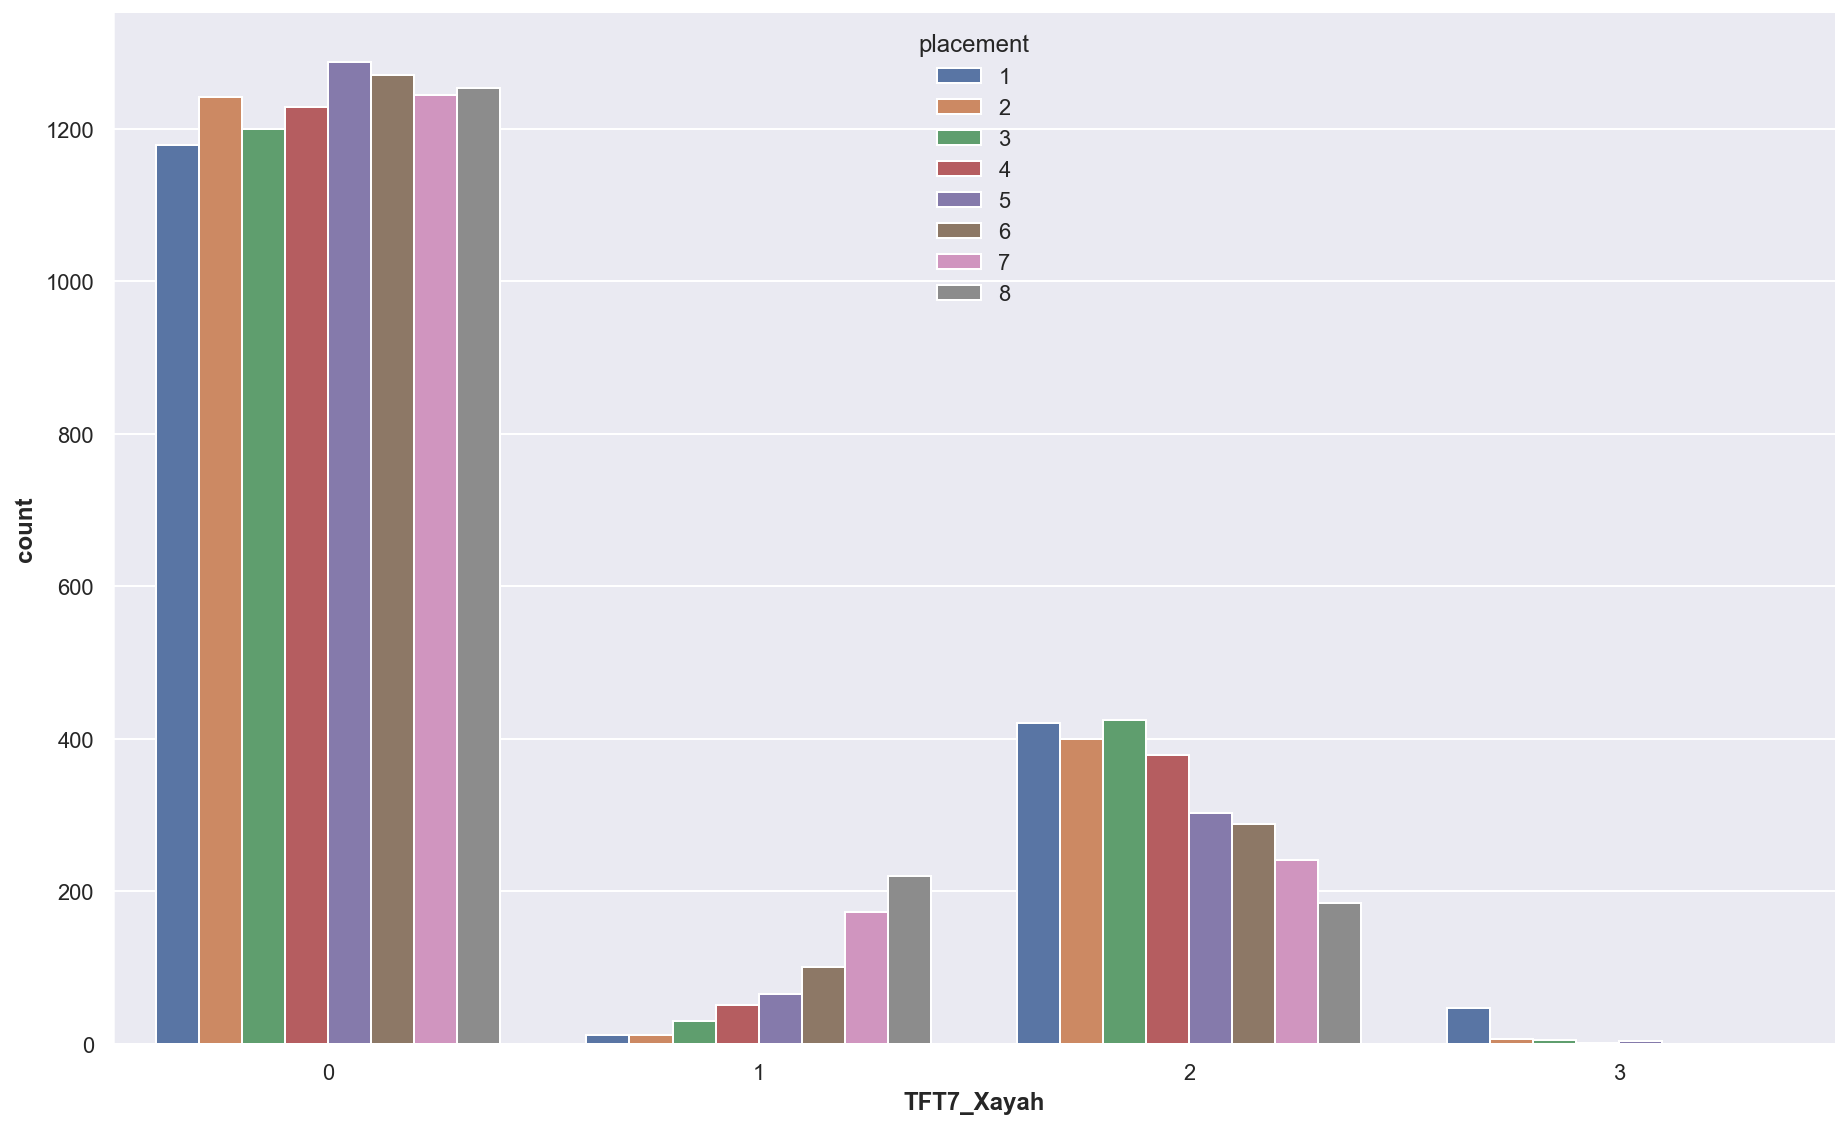

In [1218]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Xayah']>=0], x='TFT7_Xayah', hue=TARGETNAME)
sns.despine()

# Augment

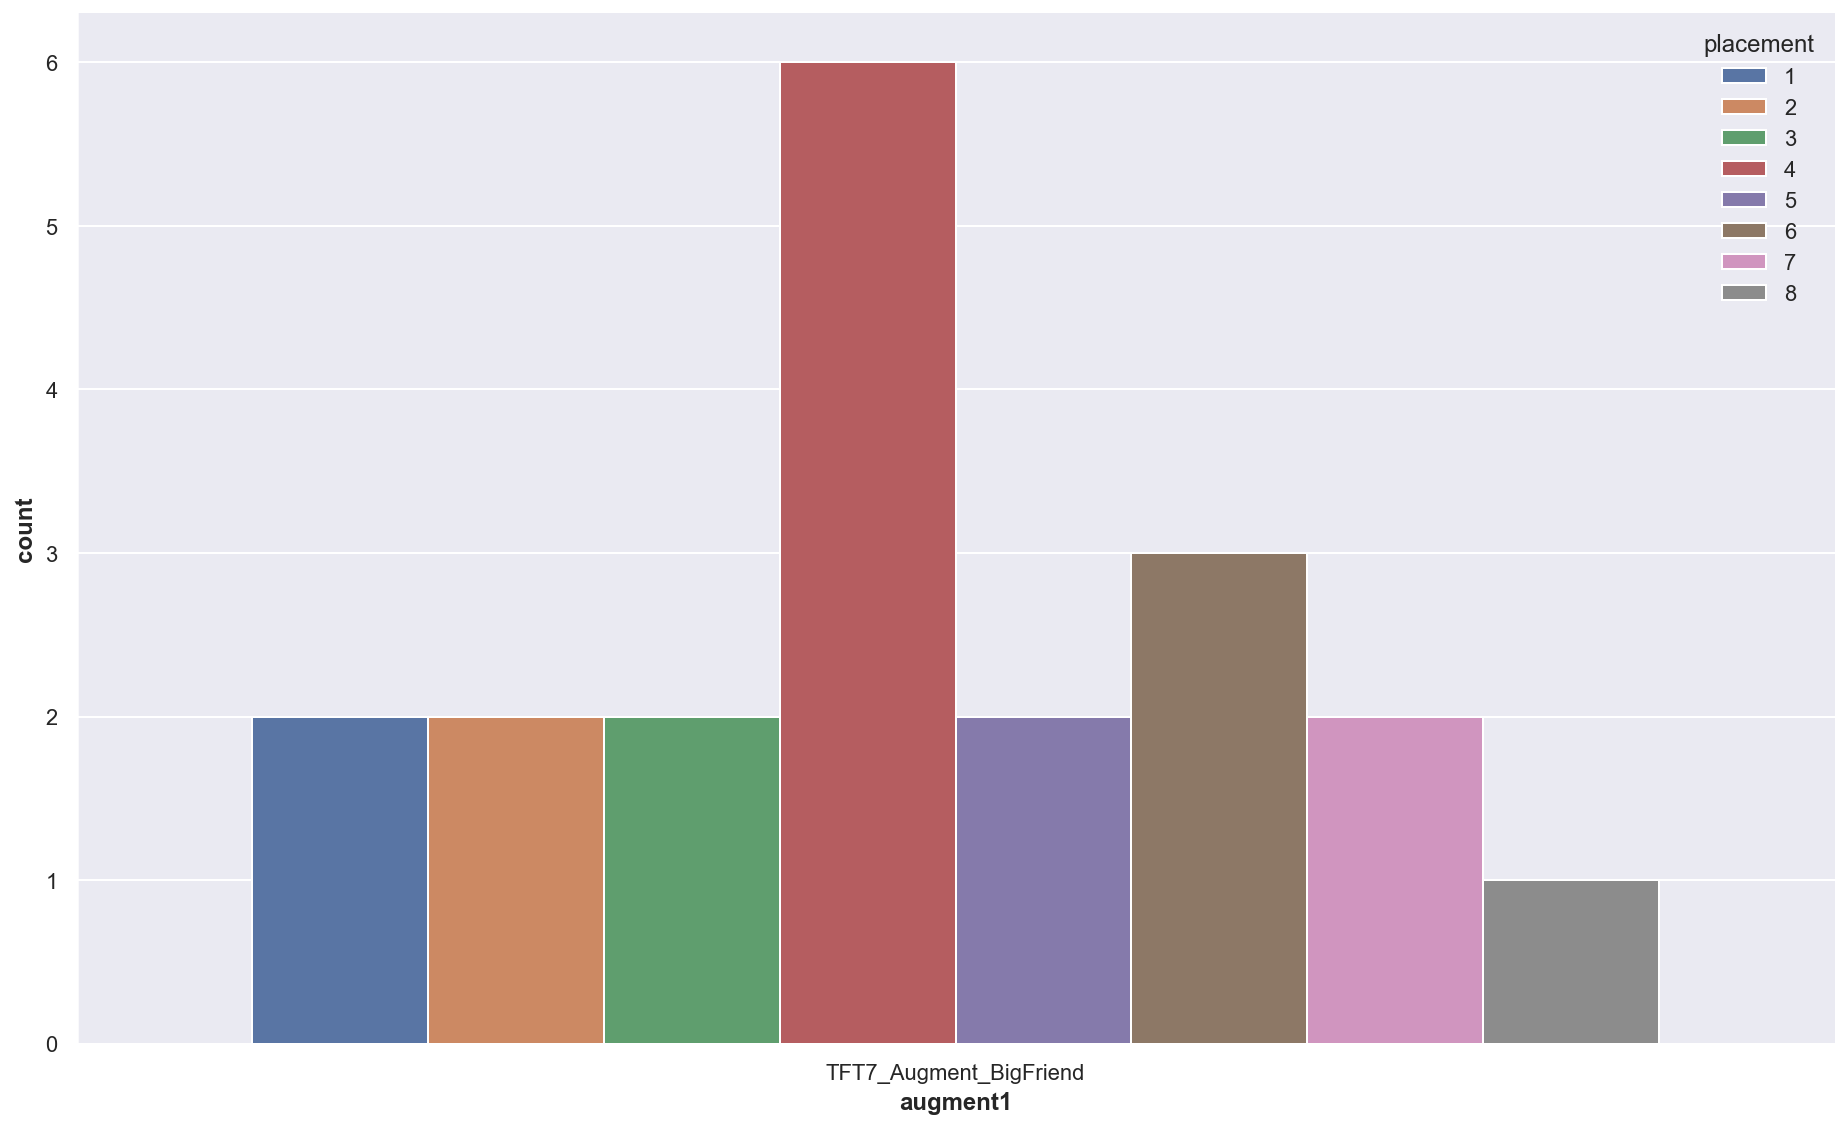

In [1219]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['augment1']=='TFT7_Augment_BigFriend'], x='augment1', hue=TARGETNAME)
sns.despine()

In [1220]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

# Baseline Model

In [1221]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [1222]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', 
                    n_estimators=250) #, use_label_encoder=False hist tree_method='hist', enable_categorical=True,

In [1223]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label.
# y = le_target.fit_transform(y)

In [1224]:
# augment_oe.fit(X[categorical_cols[:3]])

In [1225]:
# item_oe.fit(X[categorical_cols[3:]])

In [1226]:
# categorical_cols[3:]

In [1227]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
            # ("augment", augment_oe, categorical_cols[:3]),
            # ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
        verbose_feature_names_out=False,
    ),
    xgb,
)

In [1228]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['augment0', 'augment1',
                                                   'augment2',
                                                   'TFT7_Gnar_item0',
                                                   'TFT7_Gnar_item1',
                                                   'TFT7_Gnar_item2',
                                                   'TFT7_Anivia_item0',
                                                   'TFT7_Anivia_item1',
                                                   'TFT7_Anivia_item2',
                                                   'TFT7_Neeko_item0',
                                                   'TFT7_Neeko_item1',...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [1229]:
y_pred = logistic_regression_pipeline.predict(X_test)

In [1230]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [1231]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [1232]:
len(y_test)

1990

In [1233]:
y_pred.shape

(1990,)

In [1234]:
def plot_oof(y_true, y_predict):
    area = (30 * np.random.rand(len(y_predict)))**2 
    # Plot y_true vs. y_pred
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_predict, s=area, color='r', alpha=0.2)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

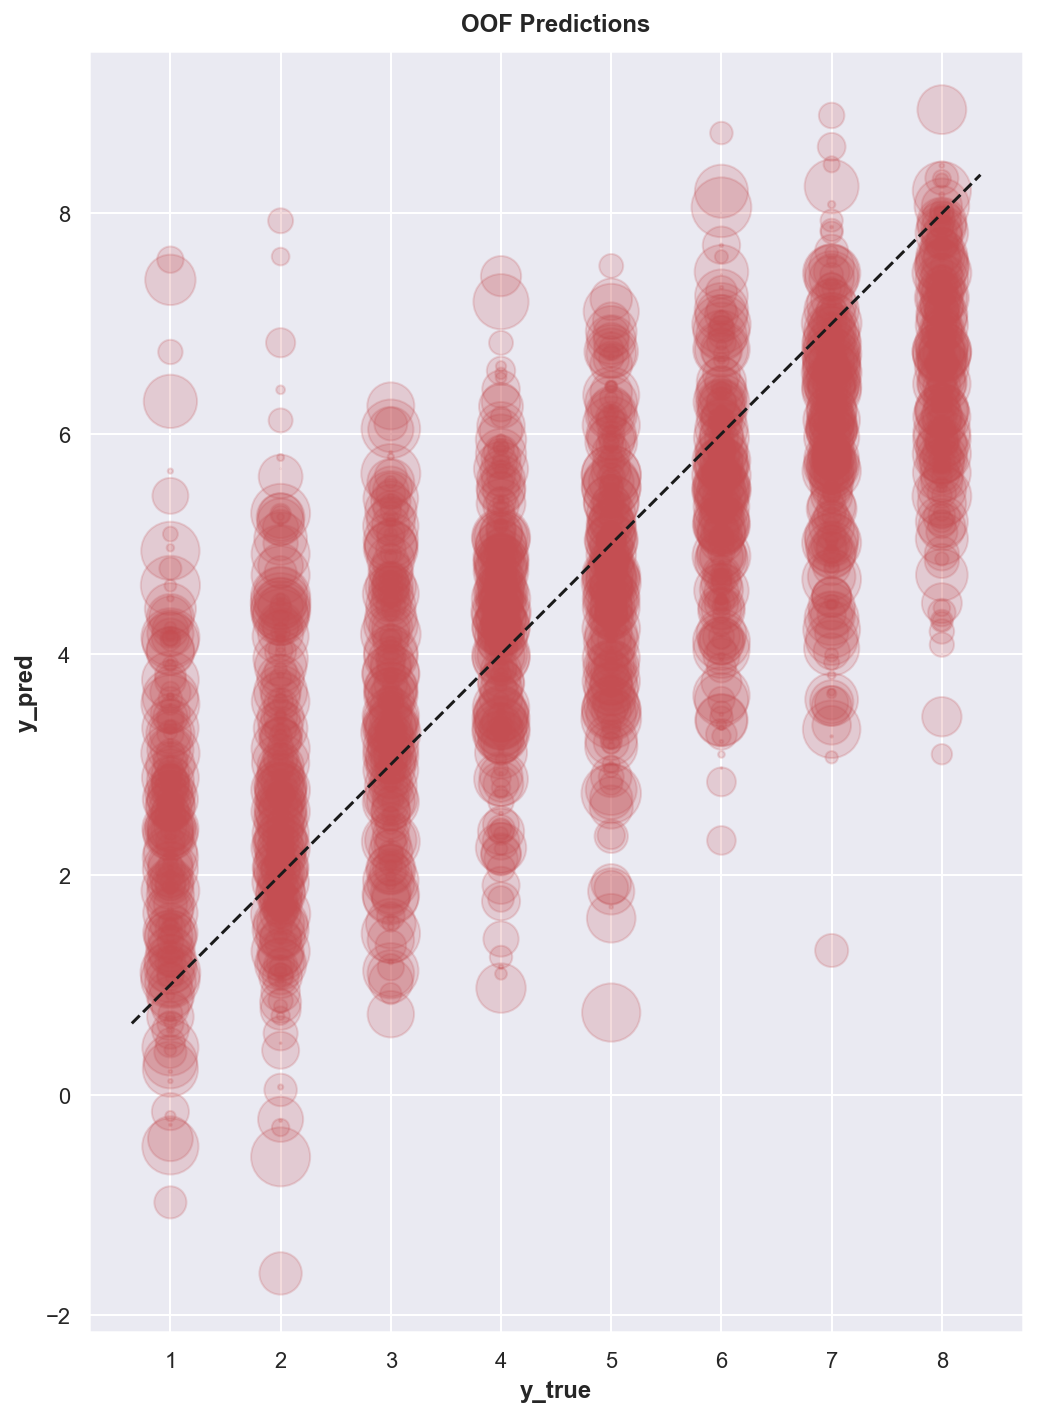

In [1235]:
plot_oof(y_test, y_pred)

In [1236]:
min(y_pred)

-1.6186917

In [1237]:
mean_absolute_error(y_test, y_pred)

1.1544626

In [1238]:
mean_squared_error(y_test, y_pred)

2.1883047

# mdi_importances

In [1239]:
feature_names = logistic_regression_pipeline[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    logistic_regression_pipeline[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

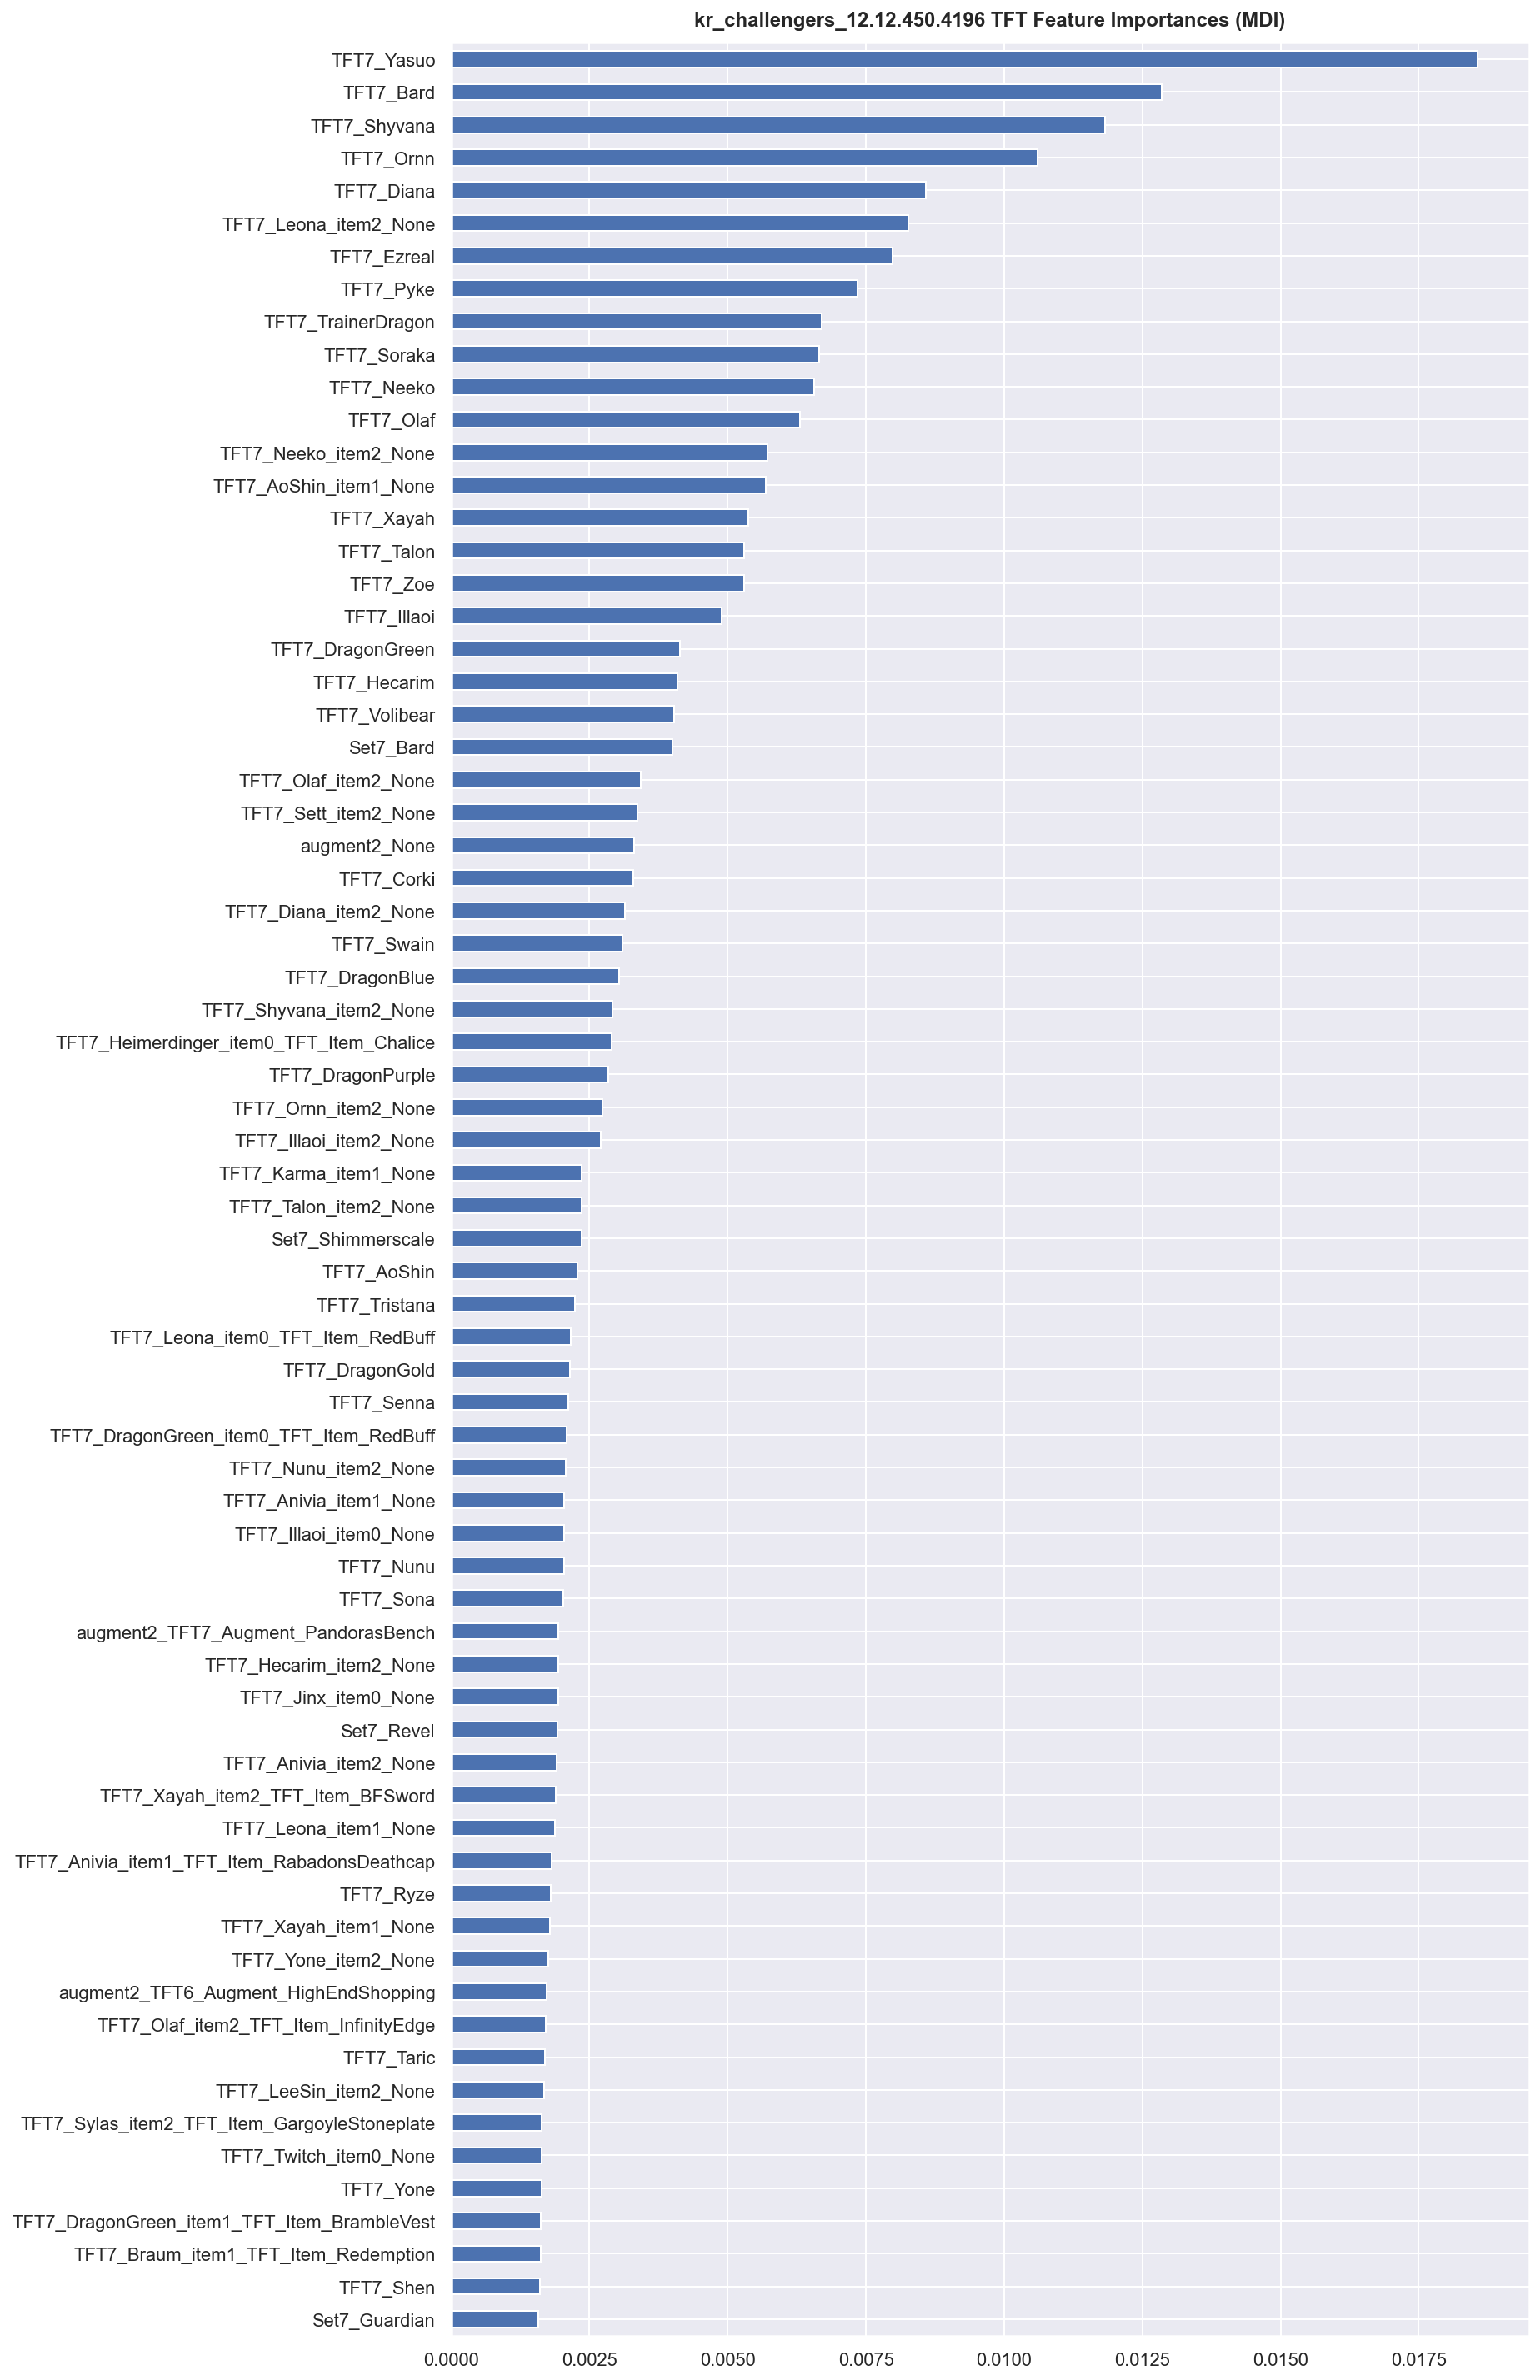

In [1243]:
plt.figure(figsize=(13, 20))
ax = mdi_importances[-70:].plot.barh()
ax.set_title(f"{SERVER}_{LEAGUE}_{LATEST_RELEASE} TFT Feature Importances (MDI)")
ax.figure.tight_layout()

In [1241]:
mdi_importances.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_mdi_importances.csv'))

In [1242]:
mdi_importances[-60:]

augment2_TFT6_Augment_HighEndShopping          0.001718
TFT7_Yone_item2_None                           0.001751
TFT7_Xayah_item1_None                          0.001783
TFT7_Ryze                                      0.001800
TFT7_Anivia_item1_TFT_Item_RabadonsDeathcap    0.001817
TFT7_Leona_item1_None                          0.001876
TFT7_Xayah_item2_TFT_Item_BFSword              0.001887
TFT7_Anivia_item2_None                         0.001899
Set7_Revel                                     0.001920
TFT7_Jinx_item0_None                           0.001933
TFT7_Hecarim_item2_None                        0.001934
augment2_TFT7_Augment_PandorasBench            0.001936
TFT7_Sona                                      0.002022
TFT7_Nunu                                      0.002033
TFT7_Illaoi_item0_None                         0.002035
TFT7_Anivia_item1_None                         0.002041
TFT7_Nunu_item2_None                           0.002076
TFT7_DragonGreen_item0_TFT_Item_RedBuff        0